In [1]:
import pyabf
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from os import getcwd,listdir
import csv

# Function

## Version 2

In [33]:
def analysis_Bias(abf,volt,start_single,end_single,timeStart=0, timeEnd = None):
    abf.setSweep(0,channel=4)
    bias = np.digitize(abf.sweepY[timeStart:timeEnd],bins = [(volt-100)/2])
    if volt<100:
        bias = 1-bias
    close_index = []
    far_index = []
    index = []
    debug = False #When debugging, set debug to True

    # Solving starting with a single far point problem
    if start_single:
        close_flag = False
    else:
        close_flag = True
        
    for i in range(0,len(bias)-1):
        dif = bias[i+1]-bias[i]
        
        #只需考慮bias差值小於-1的部分（下降點）
        #另外應該從volt點下降，10是寬限，比方説800mv，則下降應從於700mv
        '''
        if dif<-1 and bias[i]>volt-95 and bias[i+1]<volt-95: 
            f = False
            for gap in range(5):
                if i+gap < len(bias):
                    if bias[i+gap]<volt-95:
                        f = True
                        break
            if f == False:
                break
            '''
        if dif == -1:
            index.append(i)
            if close_flag:
                close_index.append(i)
                close_flag = False
            else:
                far_index.append(i)
                close_flag = True
    
    # Solve starting and/or ending with a single far point problem
    if start_single:
        far_index = far_index[1:]
    if end_single:
        close_index = close_index[:-1]
    
    print("Close point found: "+str(len(close_index)))
    print("Far point found: "+str(len(far_index)))
    
    if debug:
        print("Close point are:")
        for i in close_index:
            print(abf.sweepX[timeStart:timeEnd][i],bias[i])

        print("Far point are:")
        for i in far_index:
            print(abf.sweepX[timeStart:timeEnd][i],bias[i])
    return index,close_index,far_index

In [23]:
def findStable_Bias(abf,volt,start_single=False,end_single=False,mean_range=5,timeStart = 0, timeEnd = None,channel = 2):
    index,close_index,far_index = analysis_Bias(abf,volt,start_single,end_single,timeStart = timeStart,timeEnd = timeEnd)
    
    # mean_range default set as 5 because 1ms = 5 data points
    abf.setSweep(0,channel=channel)
    close = []
    far = []

    for ci in close_index:
        t = abf.sweepY[timeStart:timeEnd][ci-4:ci+1]
        mean = np.mean(np.array(t))
        close.append(mean)
        
    for fi in far_index:
        t = abf.sweepY[timeStart:timeEnd][fi-4:fi+1]
        mean = np.mean(np.array(t))
        far.append(mean)
        
    return close,far,close_index,far_index

In [24]:
def print_points_qty(abf,index):
    x = []
    abf.setSweep(0,channel = 3)
    for c in index:
        x.append(abf.sweepY[c]) # Record X-axis value
    x = np.round(x,decimals = 0) # Round to bin
    newline = False
    lastx = -1
    C = []
    temp = []
    '''
    print("X:")
    X = []
    for e in x:
        if lastx != e:
            if e>lastx:
                temp.append(e)
            else:
                X.append(temp)
                temp = [e]
        lastx = e
    X.append(temp)
    for xx in X:
        print(xx)
    temp = []
    print("X end")
    '''
    # Count the record qty according to X-axis
    for e in x:
        if lastx != e:
            if e>lastx:
                temp.append(1)
            else:
                C.append(temp)
                temp = [1]
        else:
            temp[-1]+=1
        lastx = e
    C.append(temp)

    for t in C:
        for n in t:
            print("%-2d"%n,end=' ')
        print()
    print("Total points: "+str(np.sum(C)))

In [25]:
def plot_v2(abf,volt,start_single=False,end_single=False,timeStart = 0, timeEnd = None,channel = 2):
    abf.setSweep(0,channel = channel)
    plt.figure(figsize=(18,5))
    plt.plot(abf.sweepX[timeStart:timeEnd],abf.sweepY[timeStart:timeEnd],color = 'green')
    
    #plot the stable 
    index,close_index,far_index = analysis_Bias(abf,volt,start_single,end_single,timeStart = timeStart,timeEnd = timeEnd)
    abf.setSweep(0,channel = channel)
    barX_start = []
    barY_start = []
    barX_end = []
    barY_end = []
    counting = 0
    for i in index:
        length = 21
        counting+=1
        for j in range(length):
            barX_end.append(abf.sweepX[timeStart:timeEnd][i])
            barY_end.append(abf.sweepY[timeStart:timeEnd][i]+(j-int(length/2)+1))
            barX_start.append(abf.sweepX[timeStart:timeEnd][i-4])
            barY_start.append(abf.sweepY[timeStart:timeEnd][i-4]+(j-int(length/2)+1))
        plt.annotate(str(counting),xy=(abf.sweepX[timeStart:timeEnd][i-4],abf.sweepY[timeStart:timeEnd][i-4]+(j-int(length/2)+1)+1))
    plt.scatter(barX_end,barY_end,s=1,facecolors='b', edgecolors='b')
    plt.scatter(barX_start,barY_start,s=1,facecolors='r',edgecolors='r')
    plt.ylabel(abf.sweepLabelY)
    plt.xlabel(abf.sweepLabelX)
    plt.show()
    return len(close_index),len(far_index)

Close point found: 0
Far point found: 0


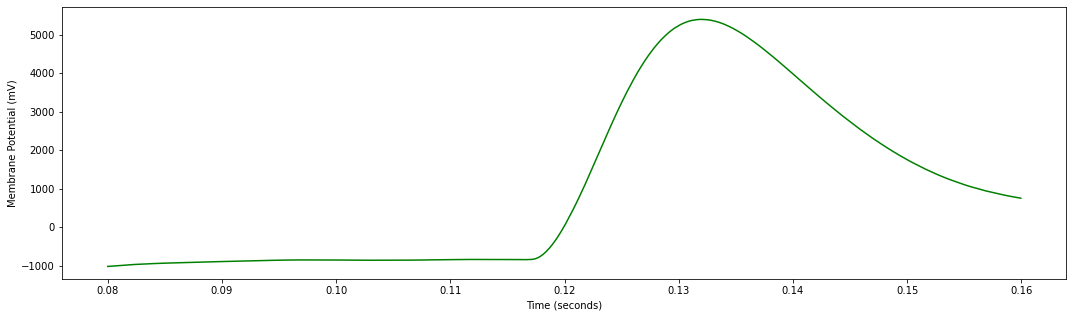

Close point found: 0
Far point found: 0


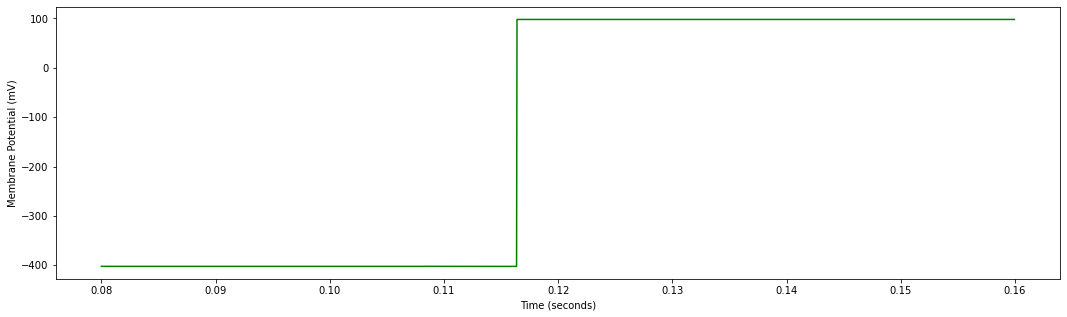

(0, 0)

In [26]:
#Test
abfFile = "22908013.abf"
volt = 800
abf = pyabf.ABF("abf\\"+abfFile)
plot_v2(abf,volt,timeStart = 2000,timeEnd = 4000,channel=2)
plot_v2(abf,volt,timeStart = 2000,timeEnd = 4000,channel=4)

## Version 1

In [27]:
# Separate AUT and Quartz
def separate(arr,Row=25,Col=100,pqty = 40,start_ignore = 4,end_ignore = 0,start_extra = 5,end_extra = 0,bias = 0):
    # start_ignore and end_ignore: extra points before reshape into rows
    # start_extra and end_extra: extra points of each rows
    # Convert end_ignore
    if end_ignore == 0:
        end_ignore = None
    else:
        end_ignore = -end_ignore
        
    # Convert end_extra
    if end_extra == 0:
        end_extra = None
        end_num = 0
    else:
        end_extra = -end_extra
        end_num = end_extra
    
    # Ignore first row
    print(6*Col + start_ignore,end_ignore)
    arr = arr[6*Col + start_ignore:end_ignore]
    arr = np.reshape(arr,(Row-1,Col+start_extra-end_num))
    aut = np.array([])
    quartz = np.array([])
    for row in arr:
        aut = np.append(aut,row[start_extra:start_extra+pqty])
        quartz = np.append(quartz,row[-pqty+end_num:end_extra])
    return aut+bias,quartz+bias

In [98]:
def plot_colormap(data,title = "AUT and QUARTZ",path = ""):
    """
    Helper function to plot data with associated colormap.
    """
   # fig, axs = plt.subplots(1, n, figsize=(n * 2 + 2, 3),
    #                        constrained_layout=True, squeeze=False)
    figure, axes = plt.subplots(figsize=(data.shape[1]/5,data.shape[0]/5))
    psm = axes.pcolormesh(data, cmap='rainbow',rasterized=True)
    figure.colorbar(psm, ax=axes)
    axes.invert_yaxis()
    if abs(data.shape[1]-data.shape[0])<=1:
        print(data.shape[1],data.shape[0])
        axes.set_aspect('equal', adjustable='box')
    plt.title(title)
    plt.savefig(path+" "+title)
    plt.show()

# Test

## Test 01_v2 -- With start time and end time

Close point found: 2
Far point found: 2


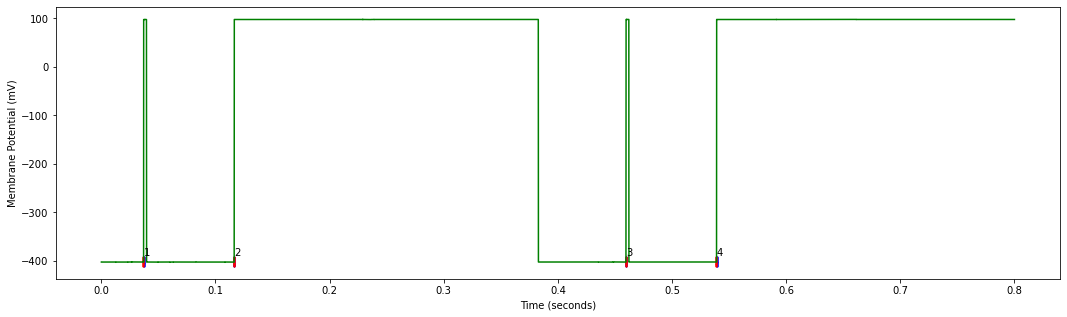

[-402.1704 -402.2314 -402.2314 ...   97.8296   97.8906   97.8906]


In [40]:
timeStart = 0
timeEnd = 20000
plot_v2(abf,volt,timeStart = timeStart, timeEnd = timeEnd,channel=4)
print(abf.sweepY[timeStart:timeEnd])

## Test 02_v2 -- Check all graph

Time: 0 ~ 200050
Close point found: 0
Far point found: 0


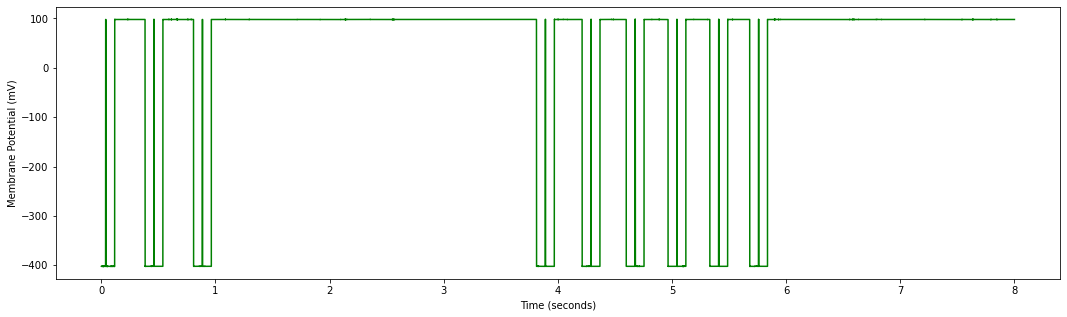

Time: 200000 ~ 400050
Close point found: 0
Far point found: 0


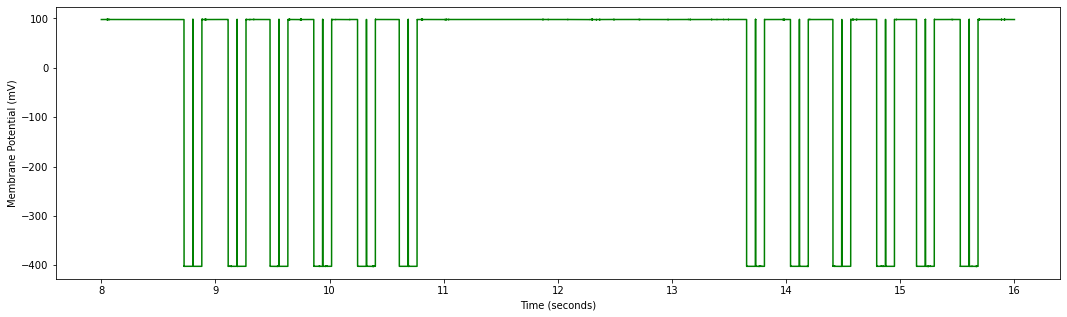

Time: 400000 ~ 600050
Close point found: 0
Far point found: 0


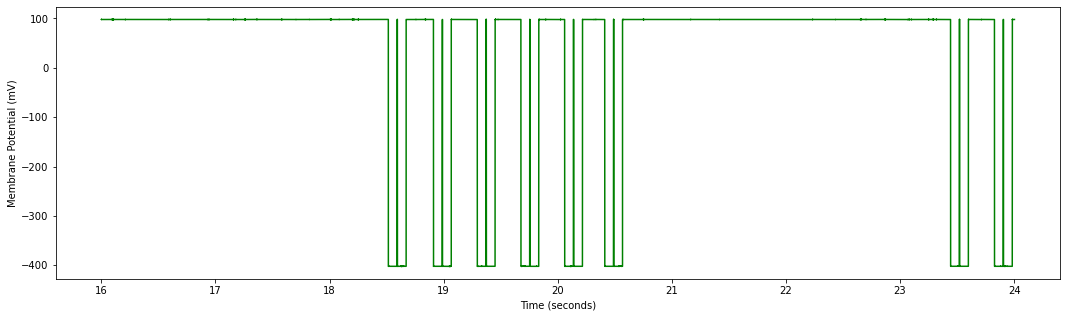

Time: 600000 ~ 800050
Close point found: 0
Far point found: 0


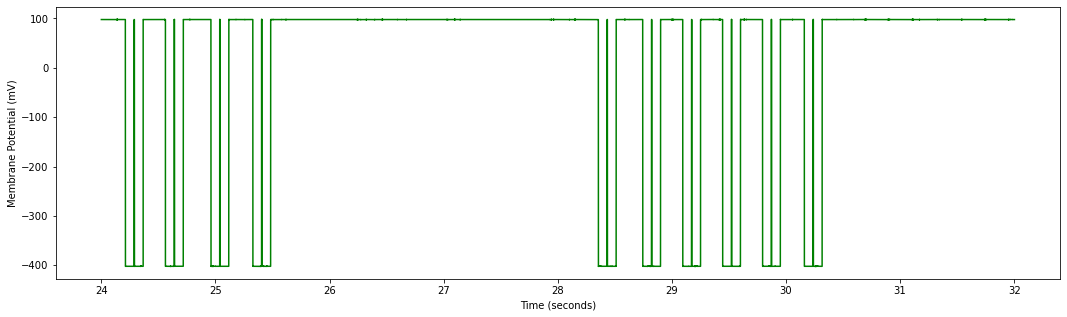

Time: 800000 ~ 1000050
Close point found: 0
Far point found: 0


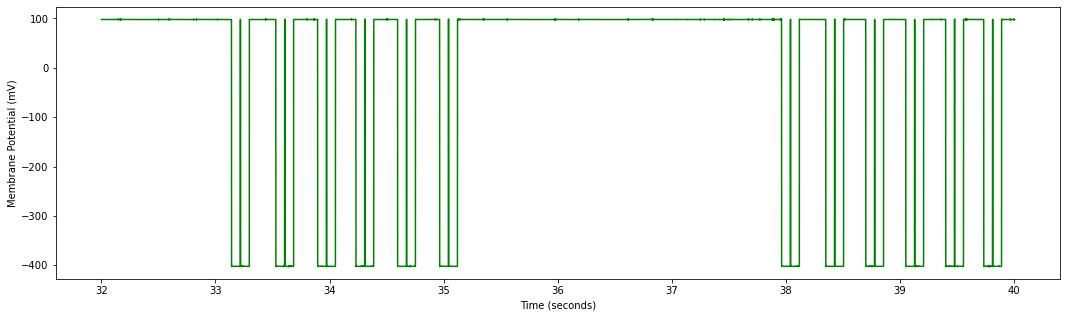

Time: 1000000 ~ 1200050
Close point found: 0
Far point found: 0


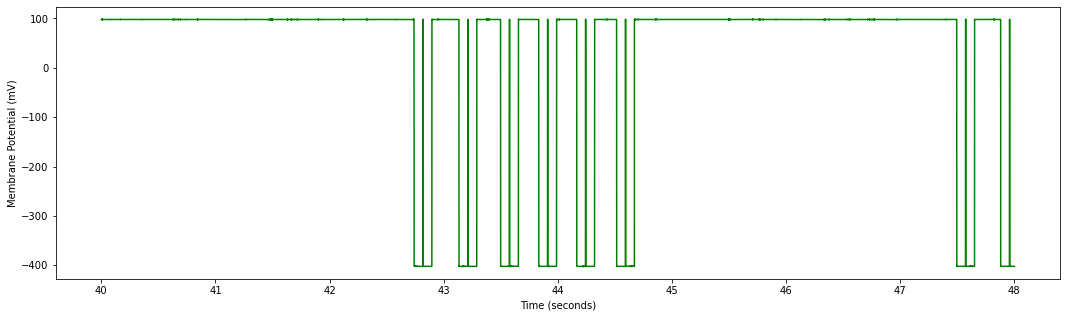

Time: 1200000 ~ 1400050
Close point found: 0
Far point found: 0


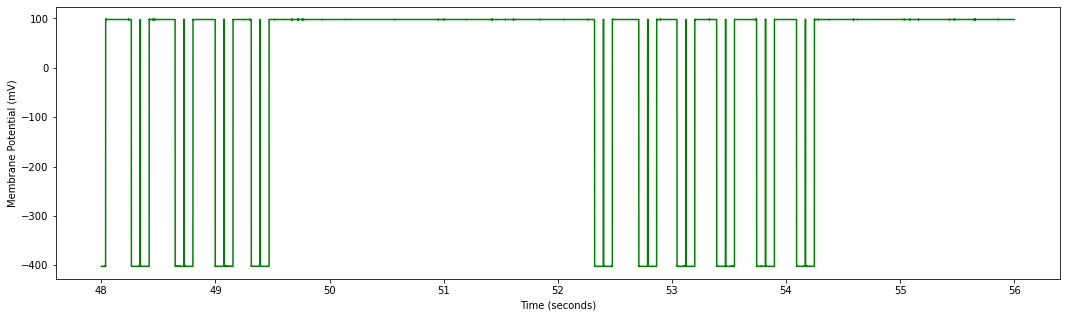

Time: 1400000 ~ 1600050
Close point found: 0
Far point found: 0


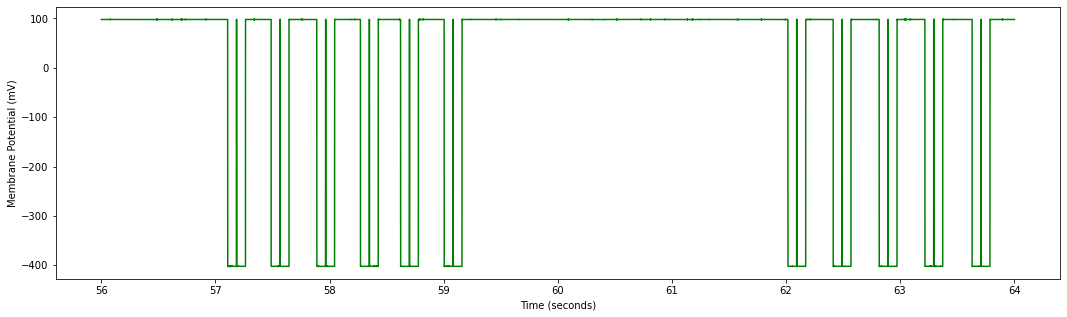

Time: 1600000 ~ 1800050
Close point found: 0
Far point found: 0


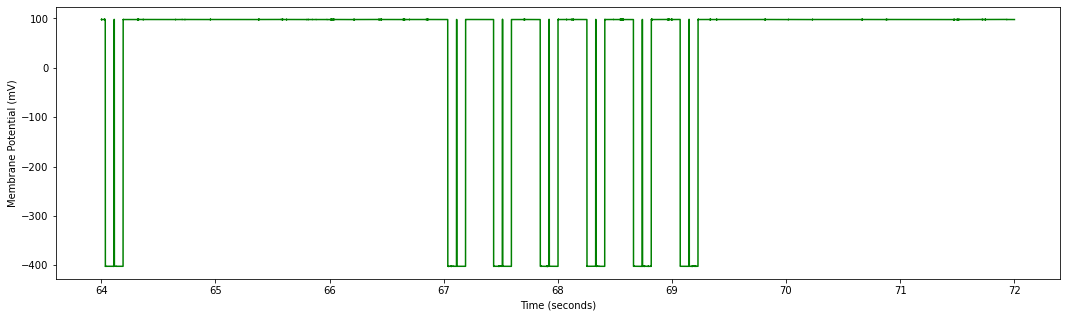

Time: 1800000 ~ 2000050
Close point found: 0
Far point found: 0


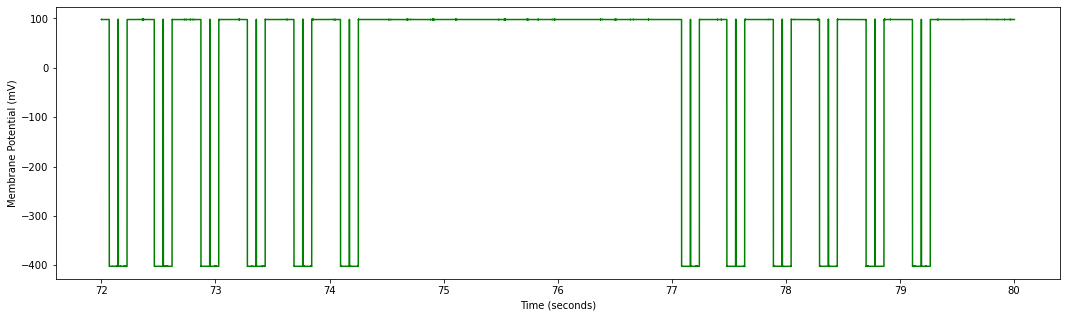

Time: 2000000 ~ 2200050
Close point found: 0
Far point found: 0


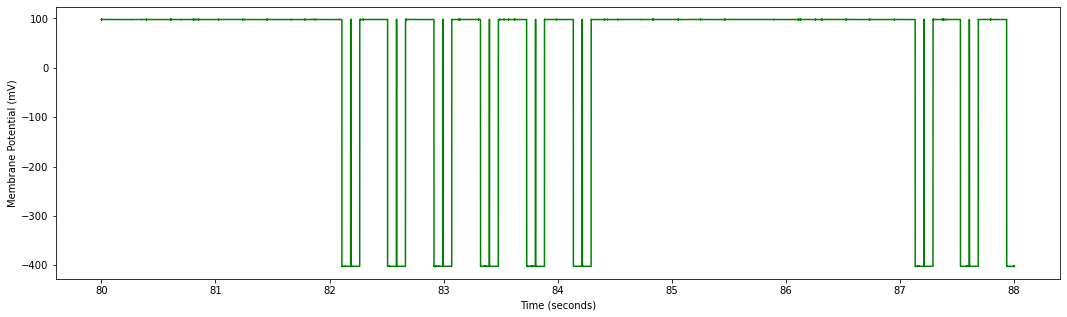

Time: 2200000 ~ 2400050
Close point found: 0
Far point found: 0


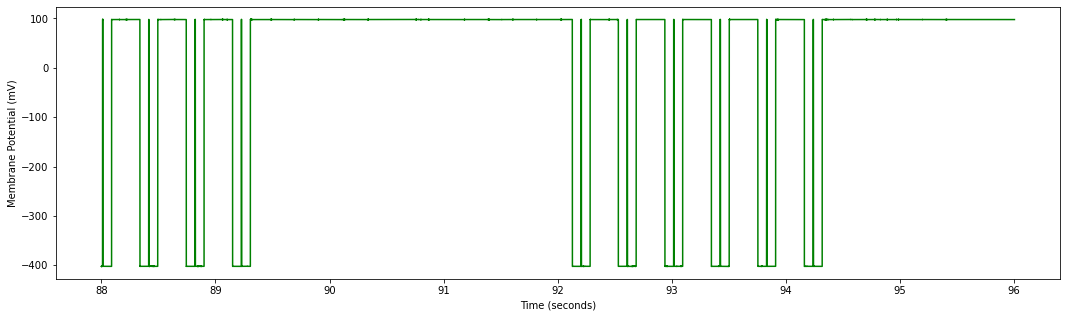

Time: 2400000 ~ 2600050
Close point found: 0
Far point found: 0


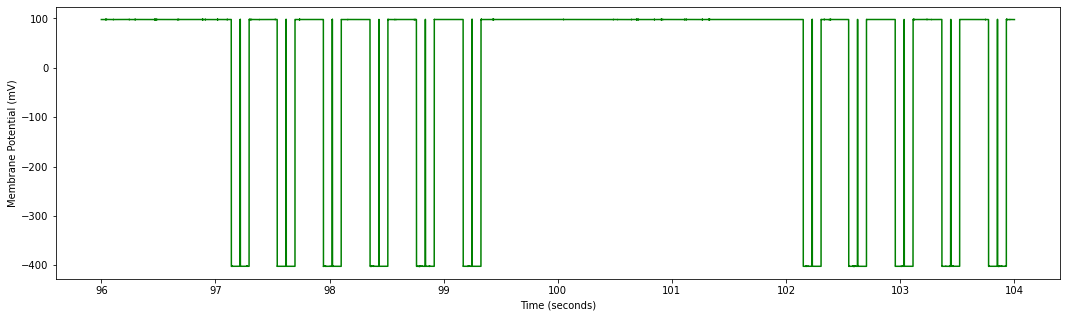

Time: 2600000 ~ 2800050
Close point found: 0
Far point found: 0


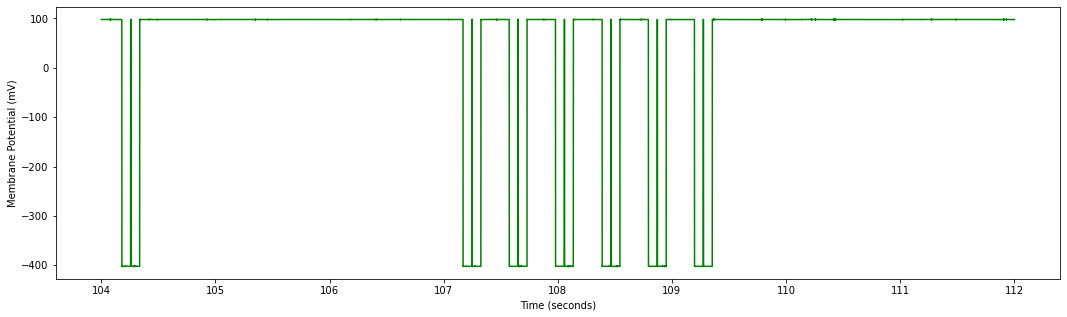

Time: 2800000 ~ 3000050
Close point found: 0
Far point found: 0


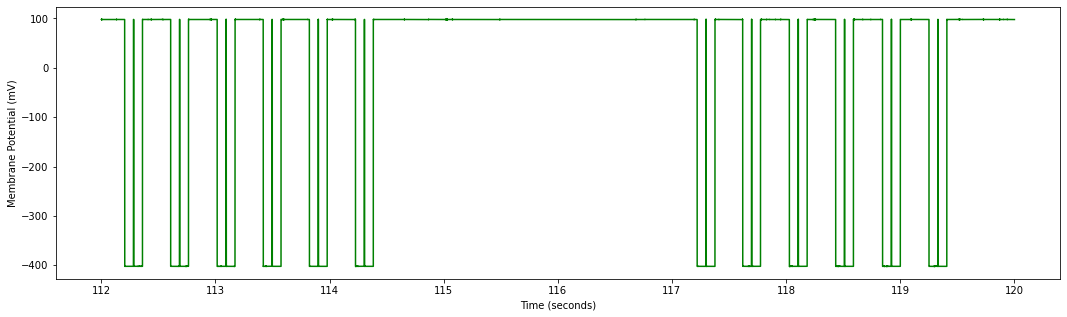

Time: 3000000 ~ 3200050
Close point found: 0
Far point found: 0


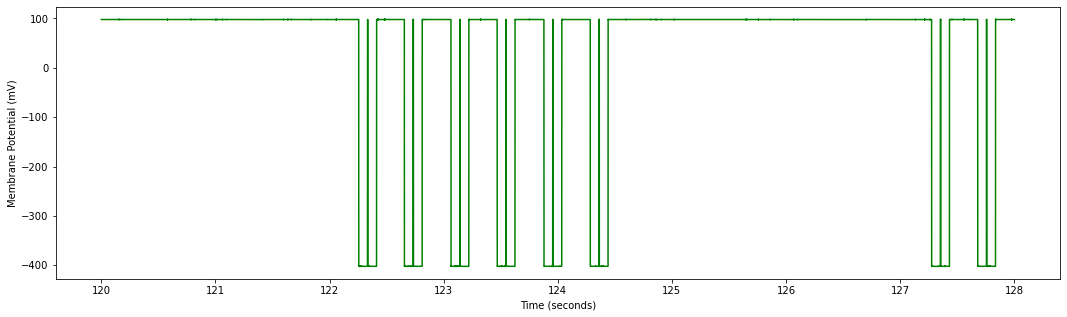

Time: 3200000 ~ 3400050
Close point found: 0
Far point found: 0


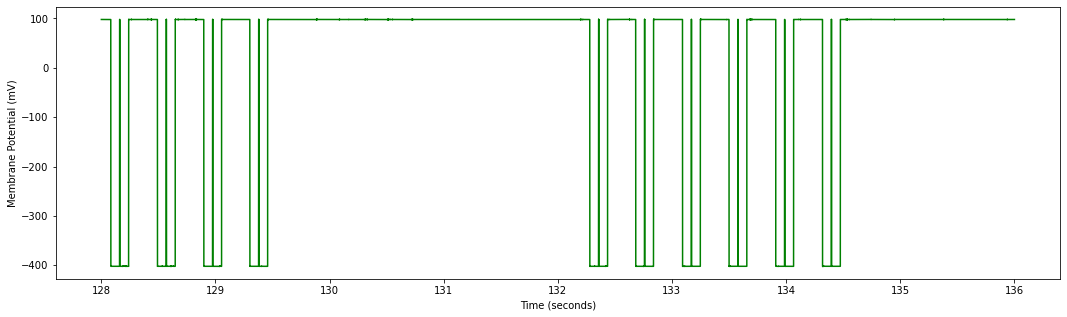

Time: 3400000 ~ 3600050
Close point found: 0
Far point found: 0


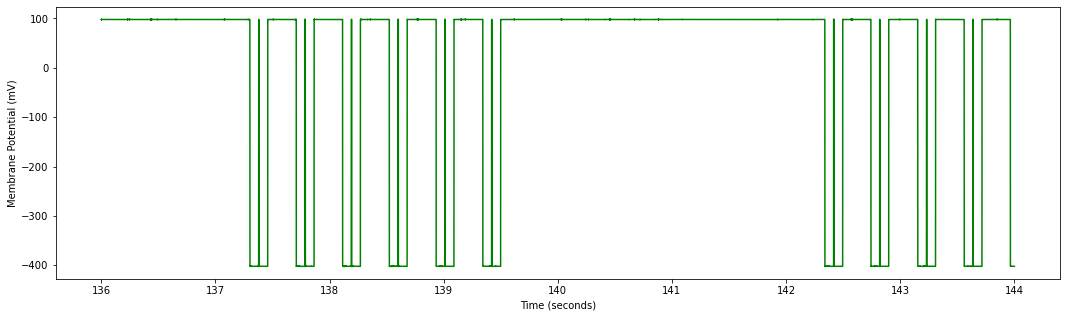

Time: 3600000 ~ 3800050
Close point found: 0
Far point found: 0


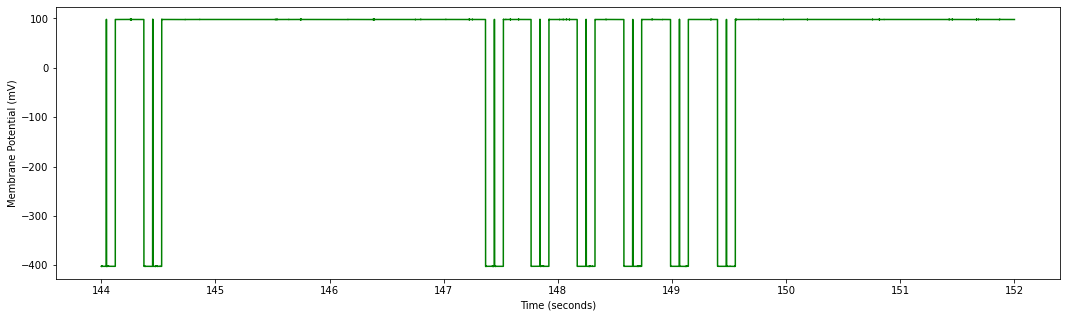

Time: 3800000 ~ 4000050
Close point found: 0
Far point found: 0


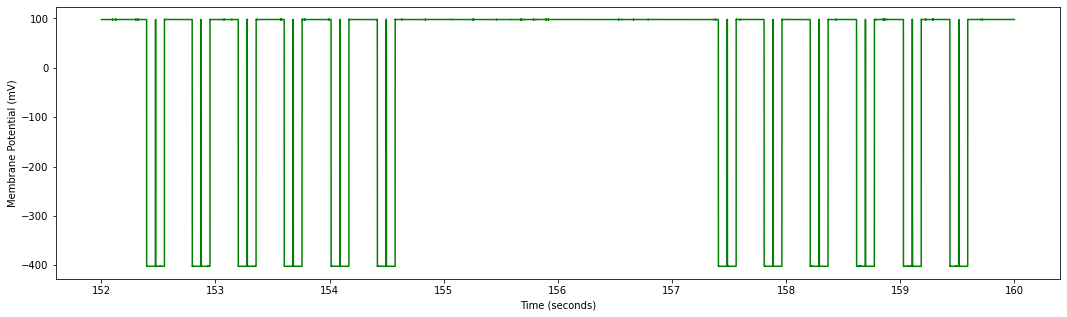

Time: 4000000 ~ 4200050
Close point found: 0
Far point found: 0


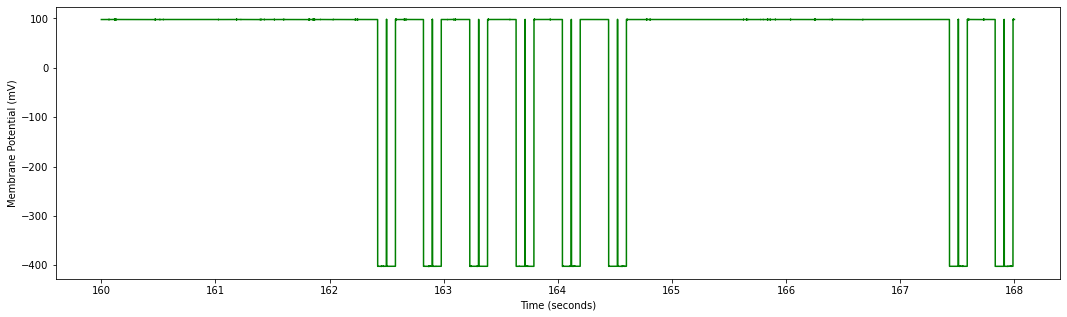

Time: 4200000 ~ 4400050
Close point found: 0
Far point found: 0


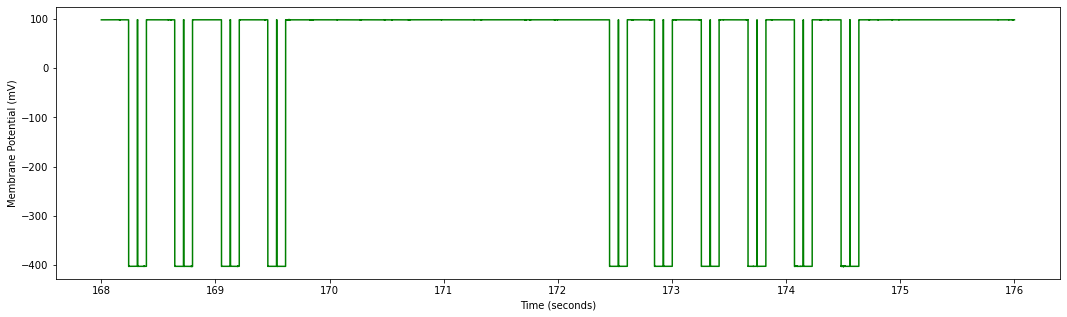

Time: 4400000 ~ 4600050
Close point found: 0
Far point found: 0


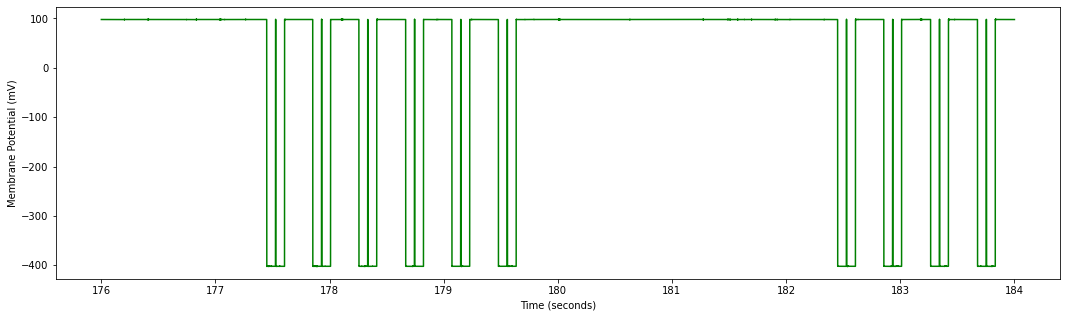

Time: 4600000 ~ 4800050
Close point found: 0
Far point found: 0


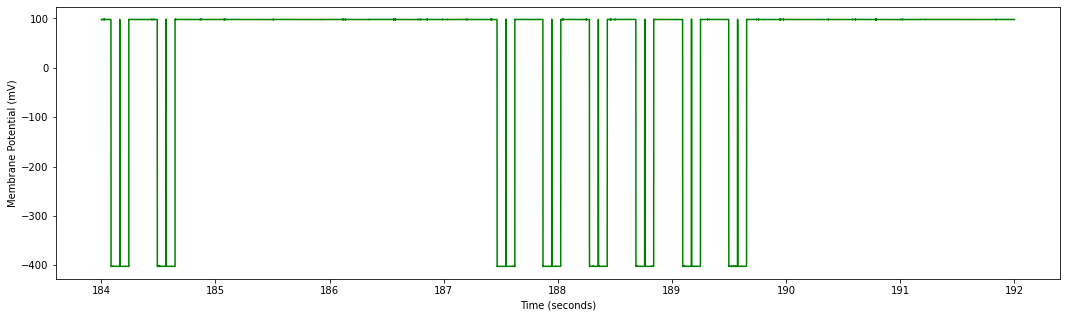

Time: 4800000 ~ 5000050
Close point found: 0
Far point found: 0


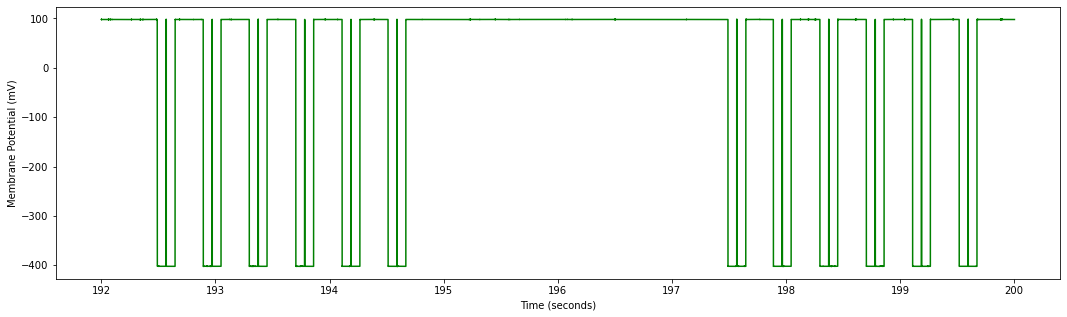

Time: 5000000 ~ 5200050
Close point found: 0
Far point found: 0


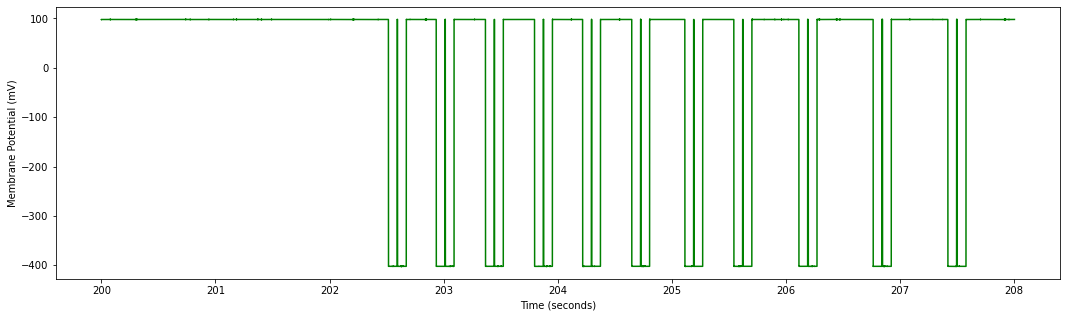

Time: 5200000 ~ 5400050
Close point found: 0
Far point found: 0


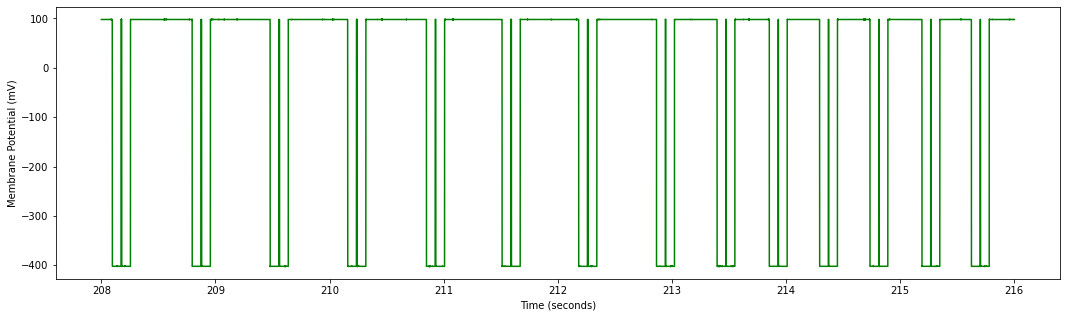

Time: 5400000 ~ 5600050
Close point found: 0
Far point found: 0


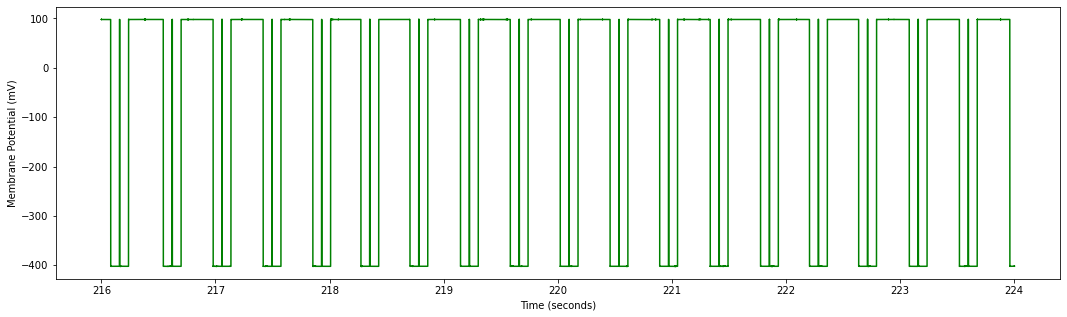

Time: 5600000 ~ 5800050
Close point found: 0
Far point found: 0


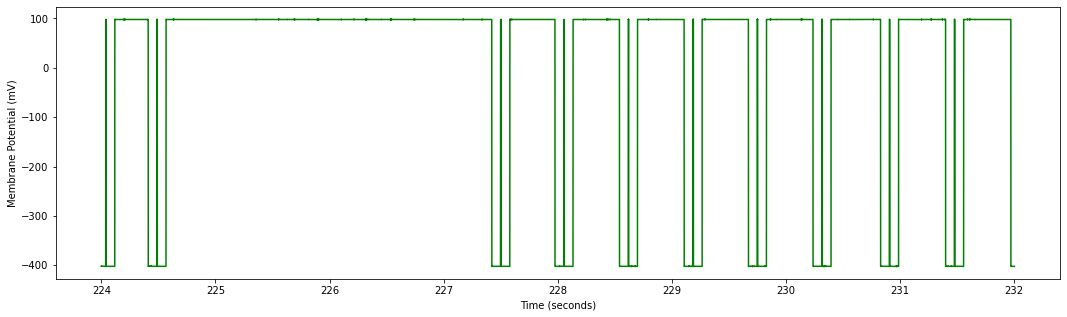

Time: 5800000 ~ 6000050
Close point found: 0
Far point found: 0


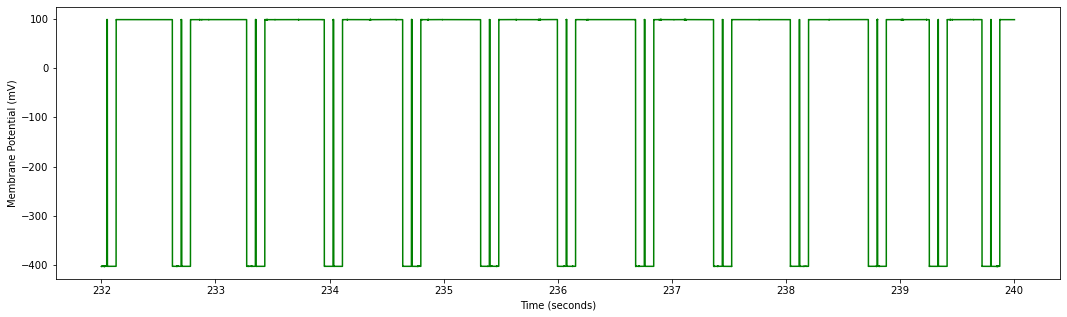

Time: 6000000 ~ 6200050
Close point found: 0
Far point found: 0


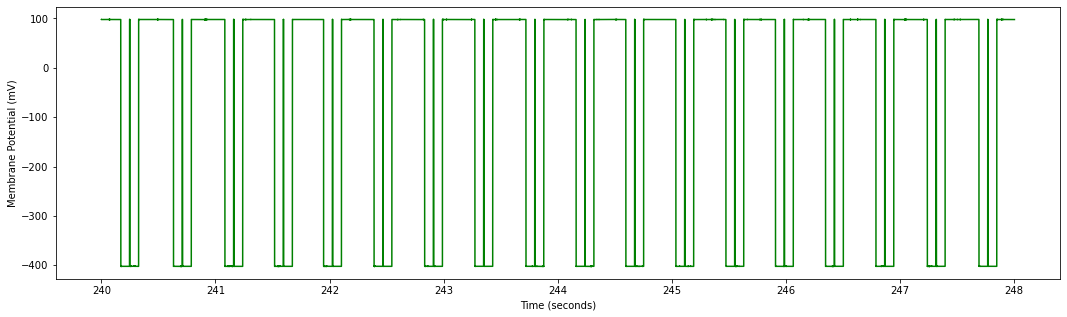

Time: 6200000 ~ 6400050
Close point found: 0
Far point found: 0


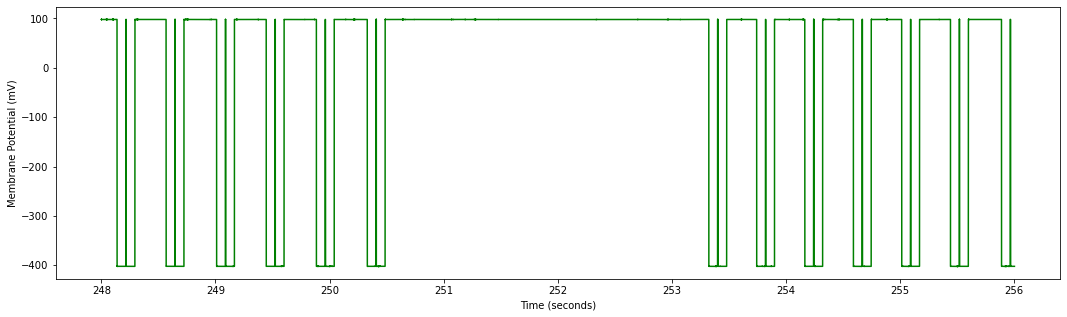

Time: 6400000 ~ 6600050
Close point found: 0
Far point found: 0


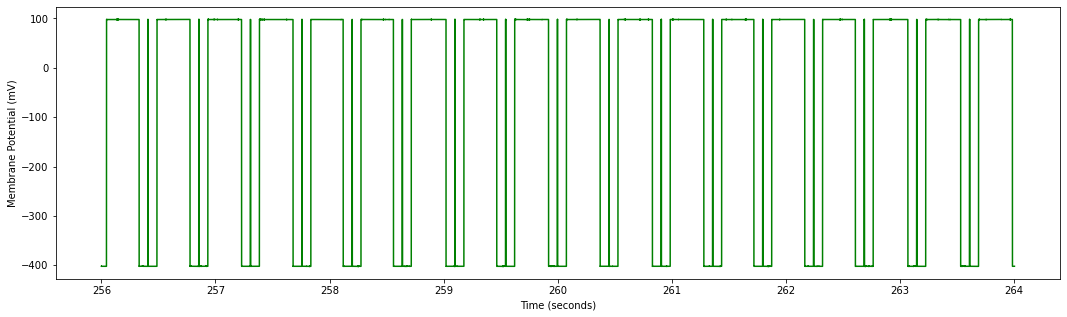

Time: 6600000 ~ 6800050
Close point found: 0
Far point found: 0


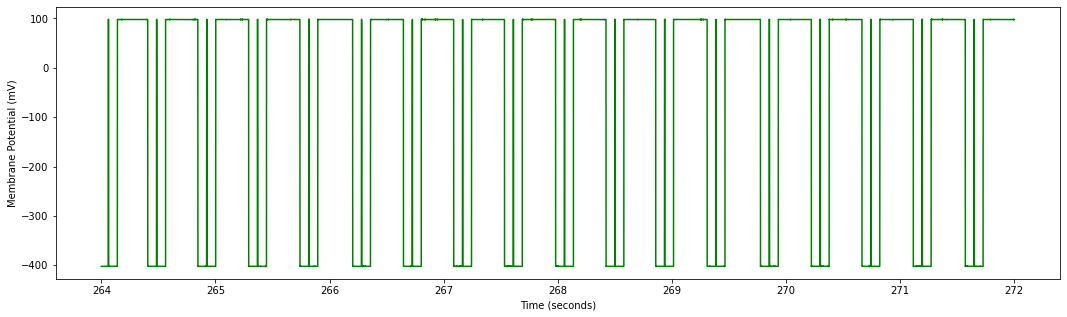

Time: 6800000 ~ 7000050
Close point found: 0
Far point found: 0


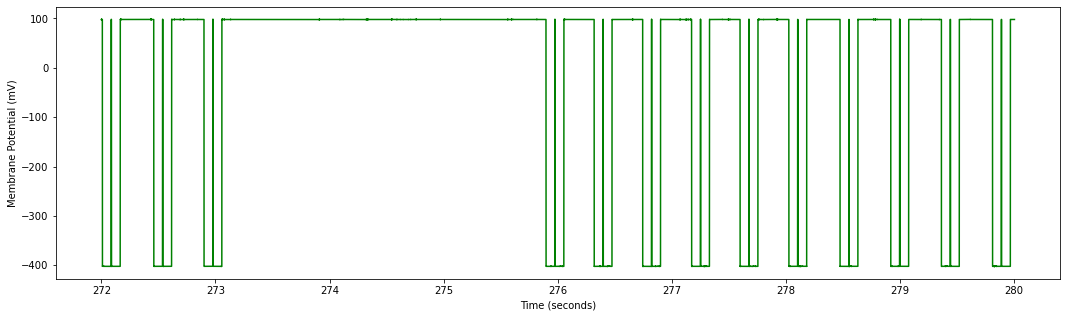

Time: 7000000 ~ 7200050
Close point found: 0
Far point found: 0


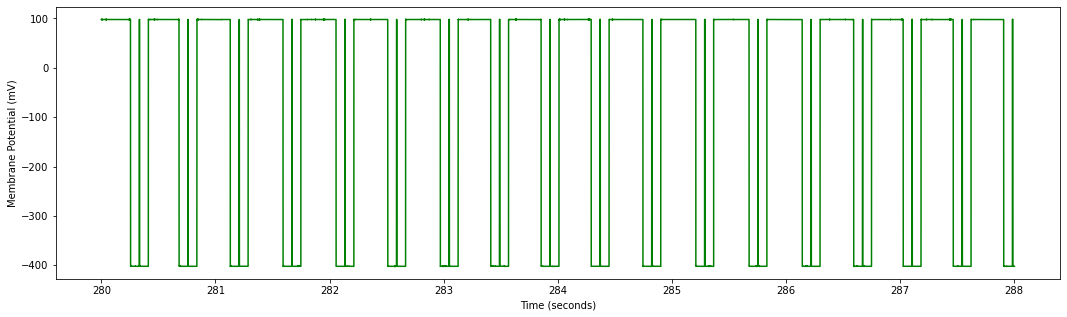

Time: 7200000 ~ 7400050
Close point found: 0
Far point found: 0


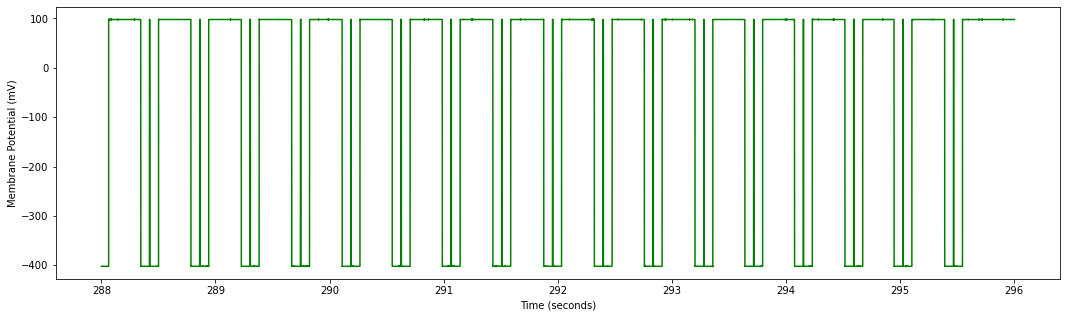

Time: 7400000 ~ 7600050
Close point found: 0
Far point found: 0


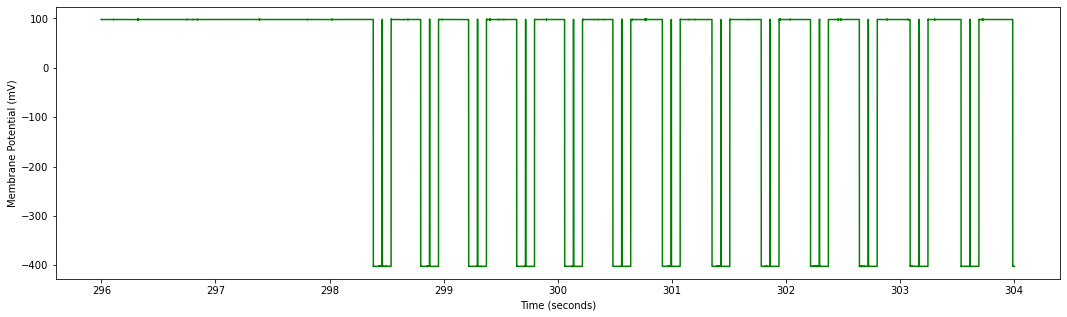

Time: 7600000 ~ 7800050
Close point found: 0
Far point found: 0


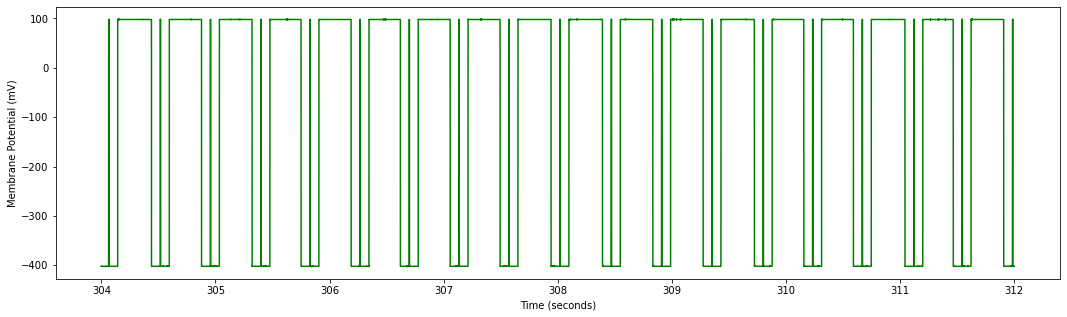

Time: 7800000 ~ 8000050
Close point found: 0
Far point found: 0


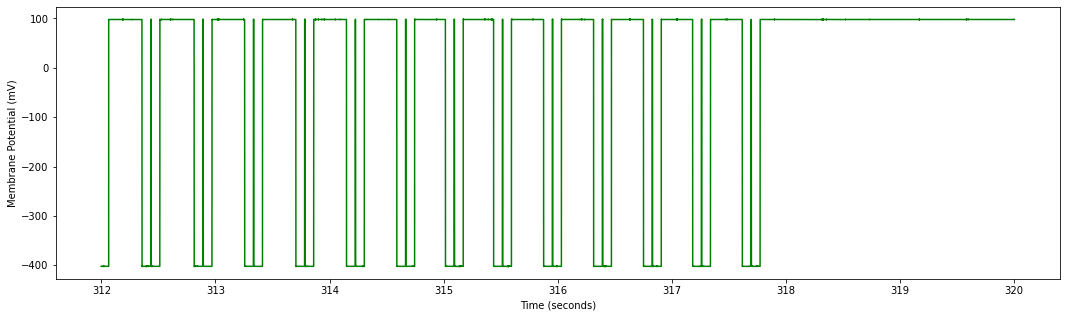

Time: 8000000 ~ 8200050
Close point found: 0
Far point found: 0


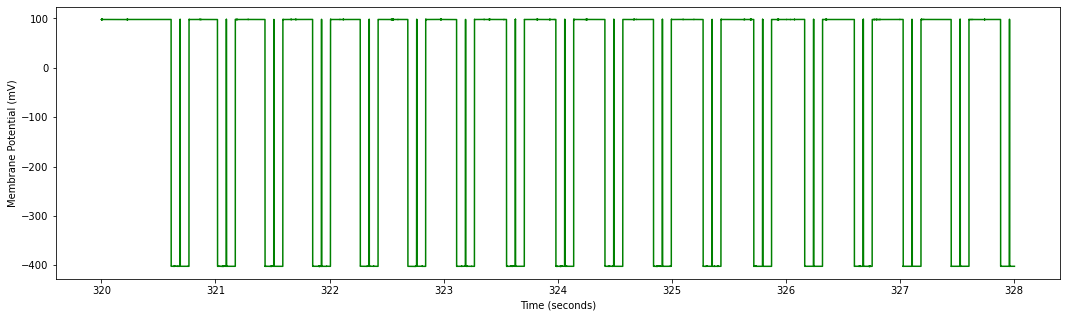

Time: 8200000 ~ 8400050
Close point found: 0
Far point found: 0


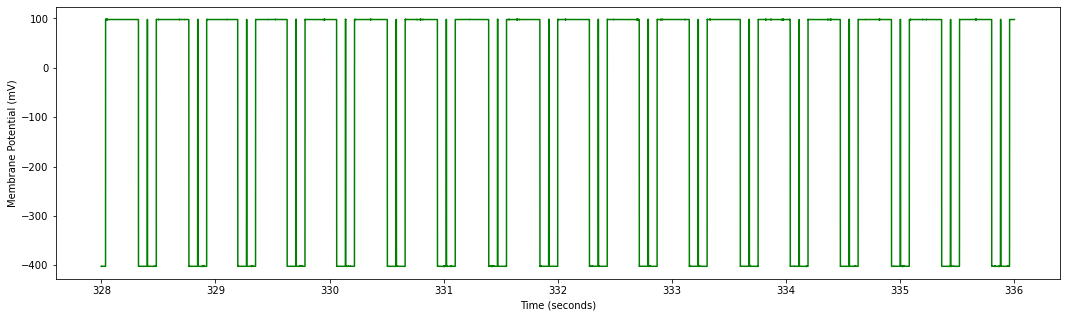

Time: 8400000 ~ 8600050
Close point found: 0
Far point found: 0


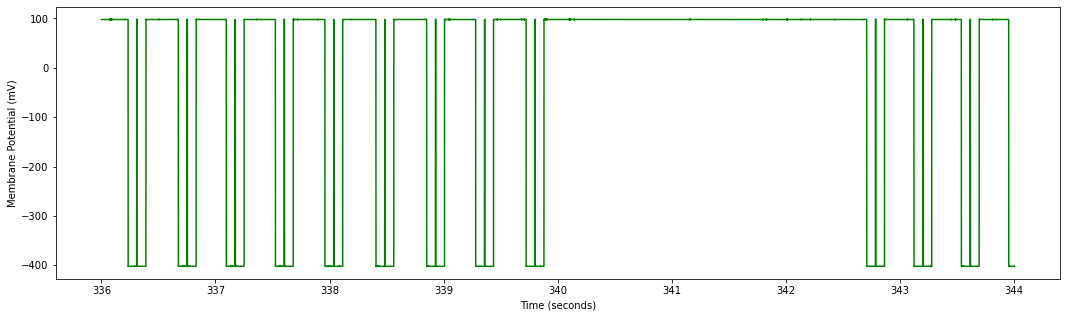

Time: 8600000 ~ 8800050
Close point found: 0
Far point found: 0


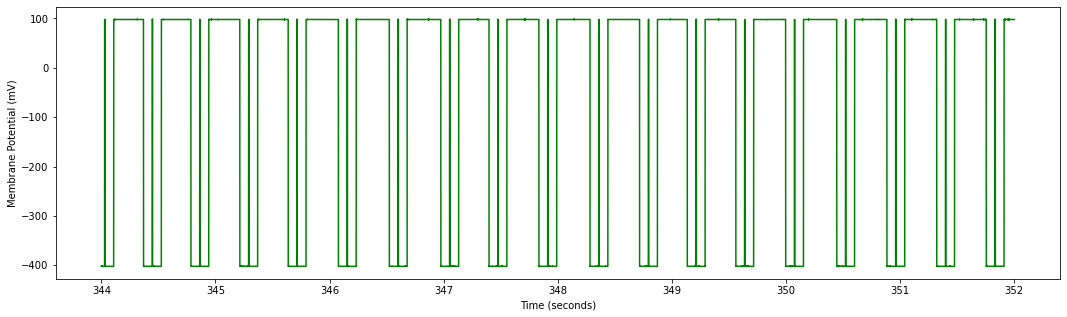

Time: 8800000 ~ 9000050
Close point found: 0
Far point found: 0


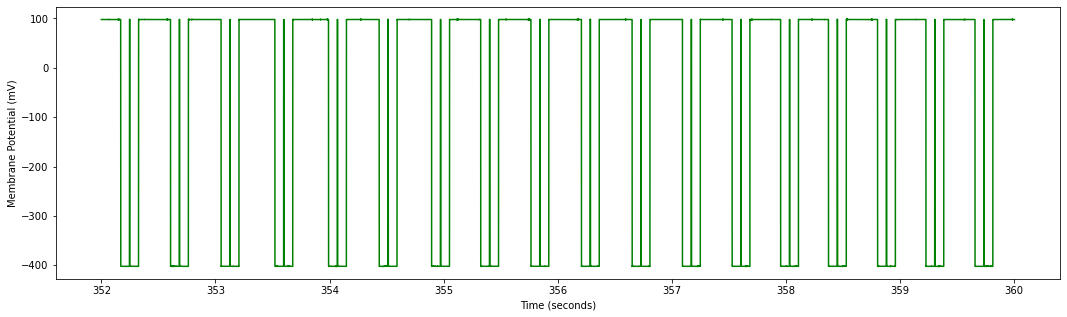

Time: 9000000 ~ 9200050
Close point found: 0
Far point found: 0


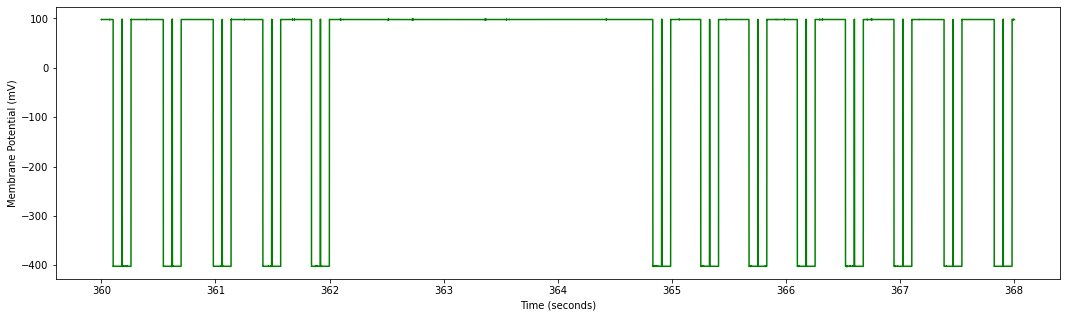

Time: 9200000 ~ 9400050
Close point found: 0
Far point found: 0


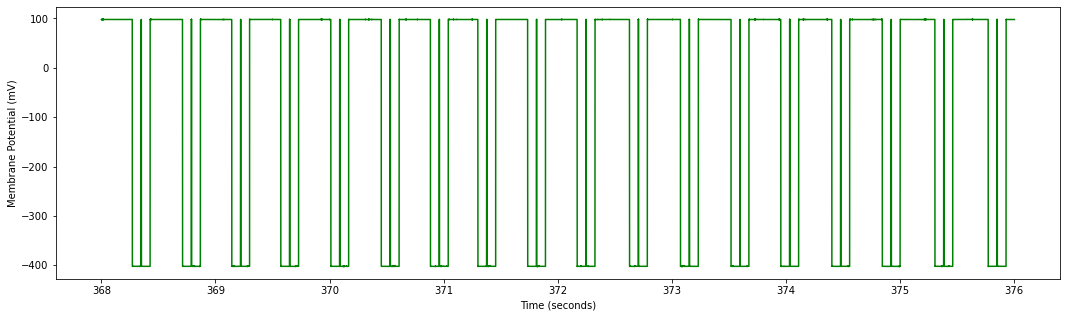

Time: 9400000 ~ 9600050
Close point found: 0
Far point found: 0


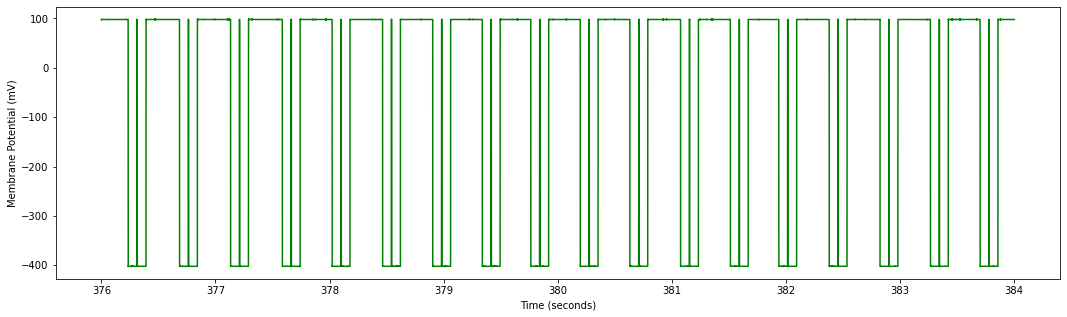

Time: 9600000 ~ 9800050
Close point found: 0
Far point found: 0


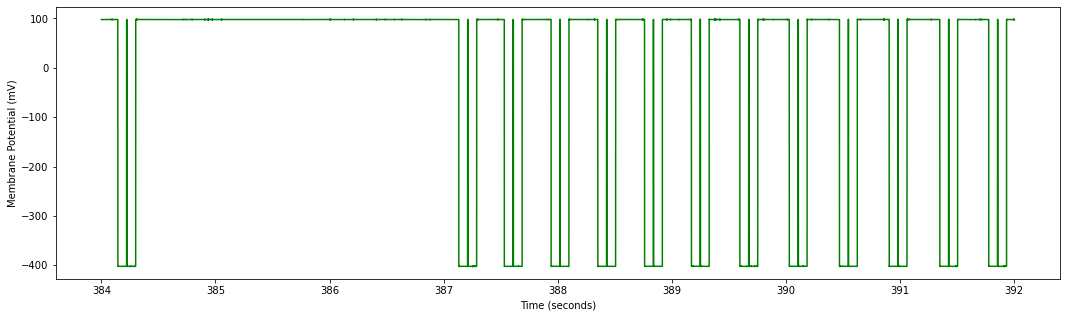

Time: 9800000 ~ 10000050
Close point found: 0
Far point found: 0


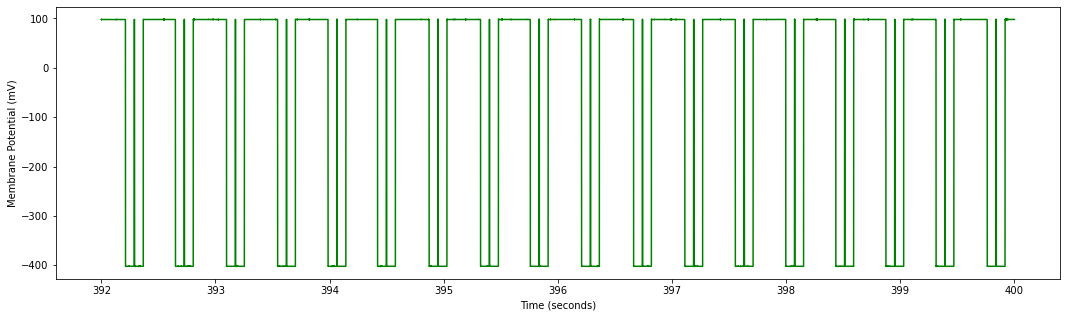

Time: 10000000 ~ 10200050
Close point found: 0
Far point found: 0


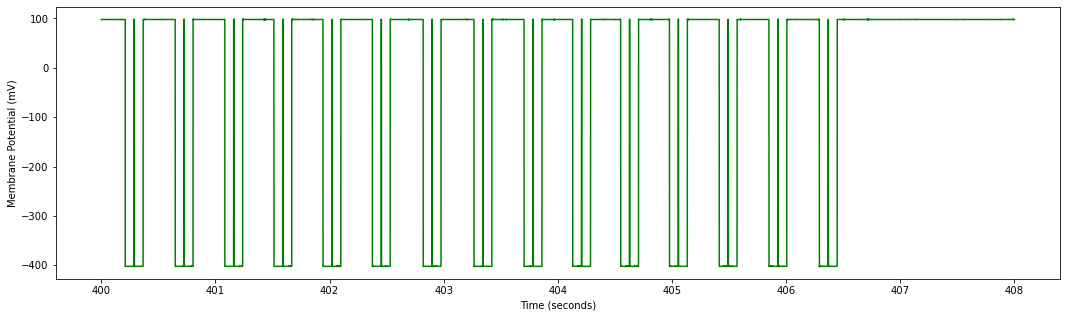

Time: 10200000 ~ 10400050
Close point found: 0
Far point found: 0


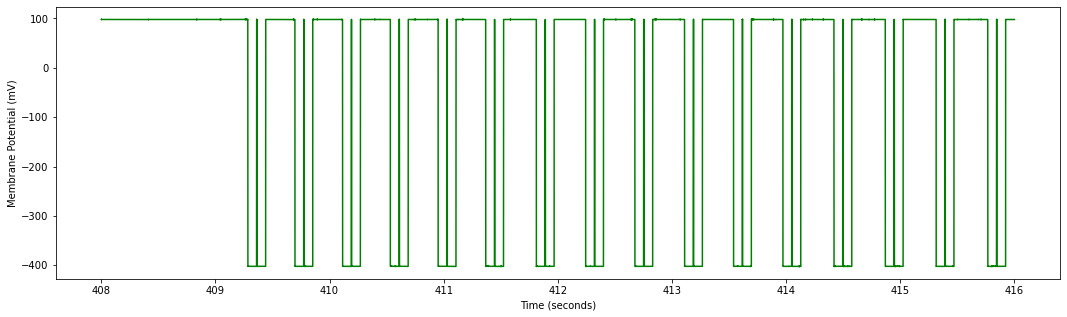

Time: 10400000 ~ 10600050
Close point found: 0
Far point found: 0


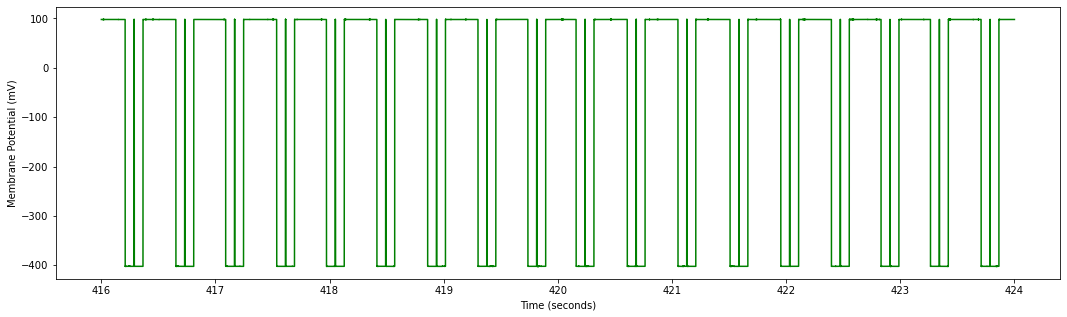

Time: 10600000 ~ 10800050
Close point found: 0
Far point found: 0


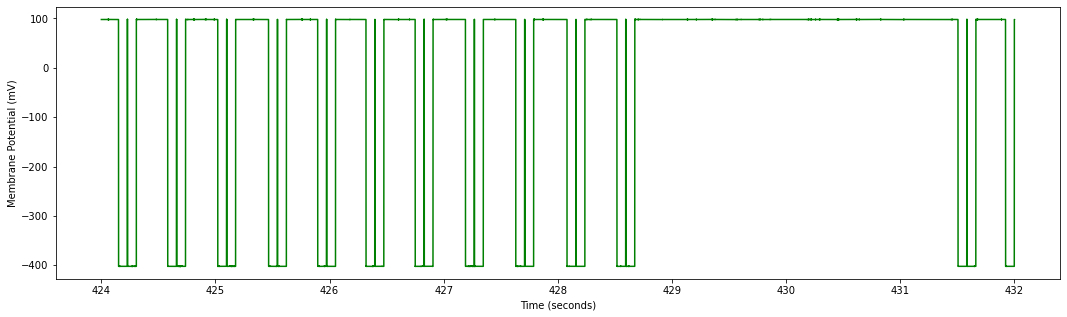

Time: 10800000 ~ 11000050
Close point found: 0
Far point found: 0


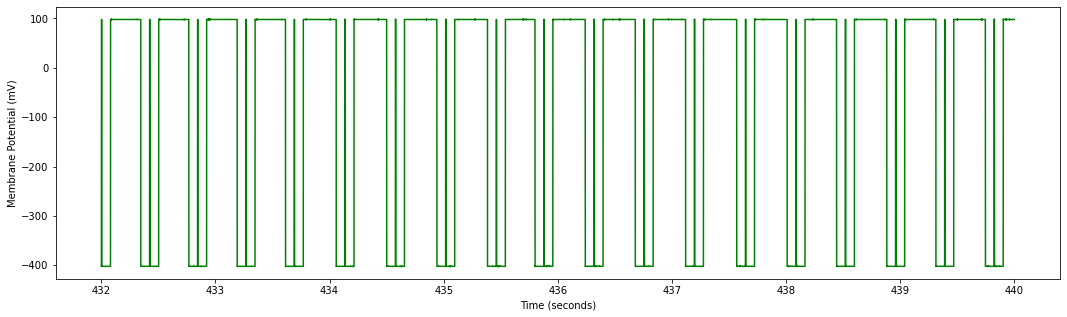

Time: 11000000 ~ 11200050
Close point found: 0
Far point found: 0


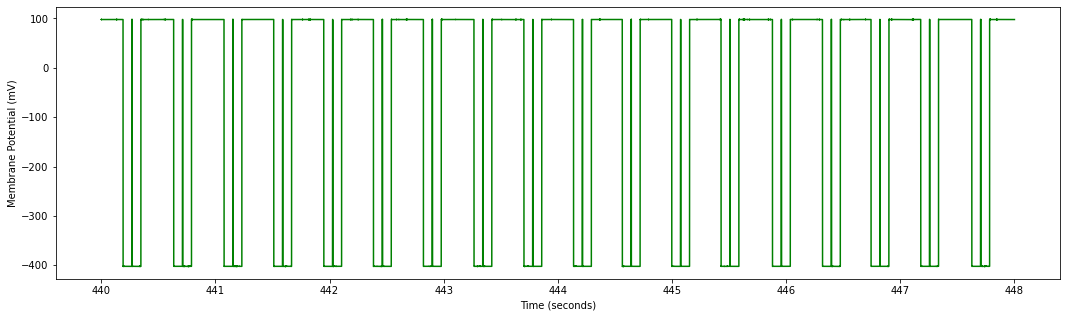

Time: 11200000 ~ 11400050
Close point found: 0
Far point found: 0


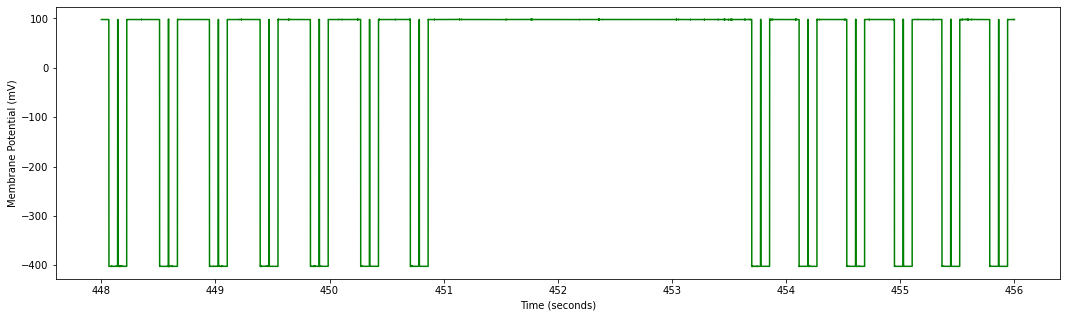

Time: 11400000 ~ 11600050
Close point found: 0
Far point found: 0


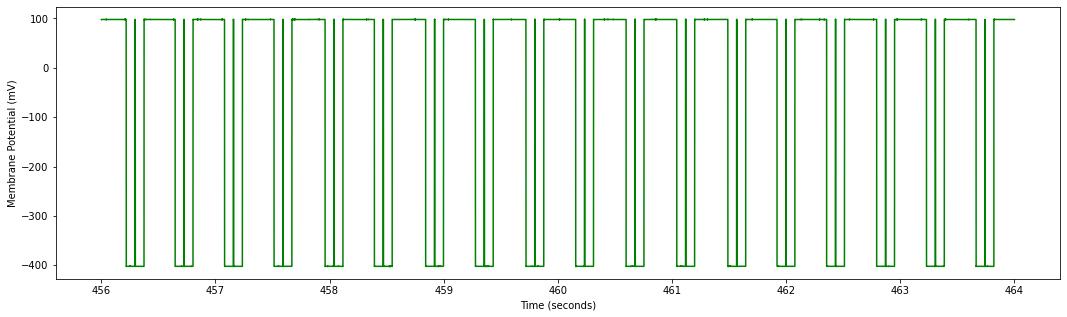

Time: 11600000 ~ 11800050
Close point found: 0
Far point found: 0


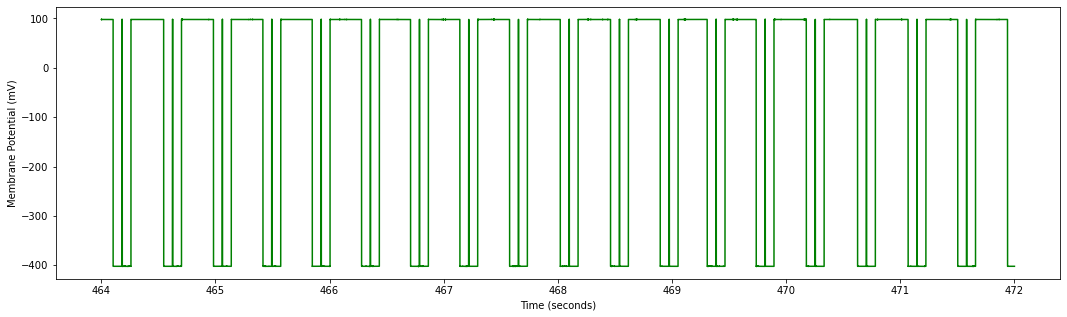

Time: 11800000 ~ 12000050
Close point found: 0
Far point found: 0


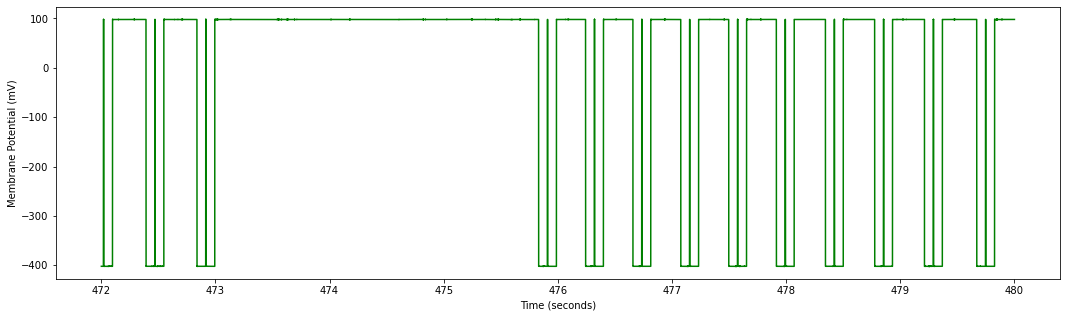

Time: 12000000 ~ 12200050
Close point found: 0
Far point found: 0


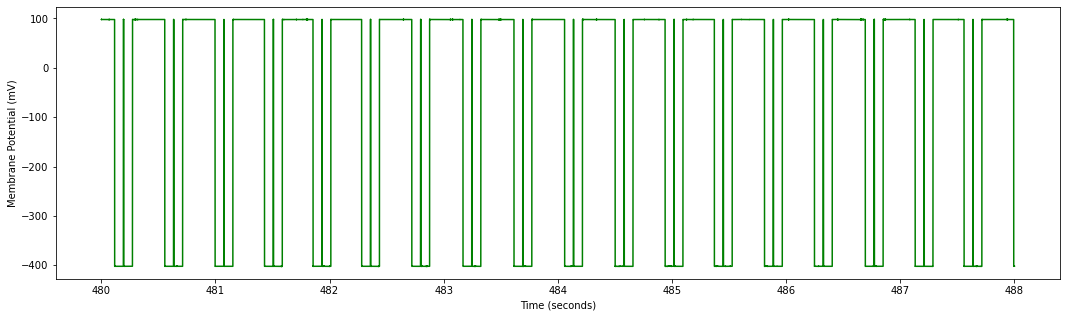

Time: 12200000 ~ 12400050
Close point found: 0
Far point found: 0


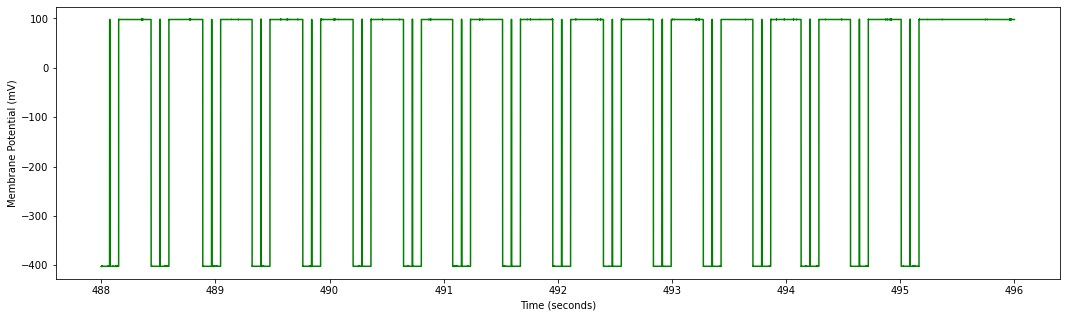

Time: 12400000 ~ 12600050
Close point found: 0
Far point found: 0


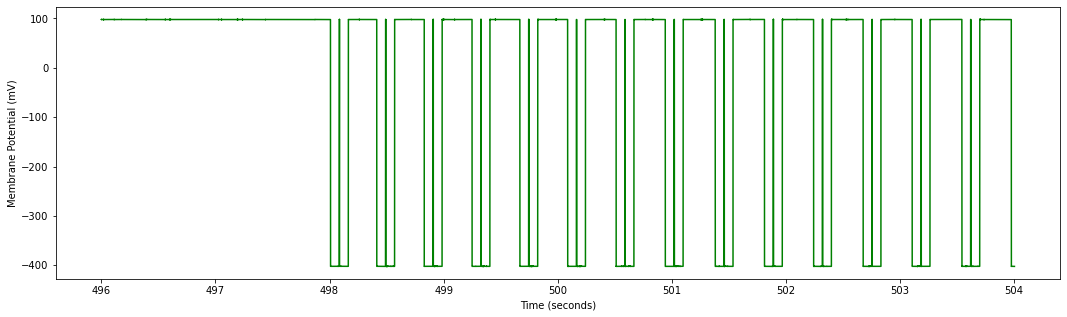

Time: 12600000 ~ 12800050
Close point found: 0
Far point found: 0


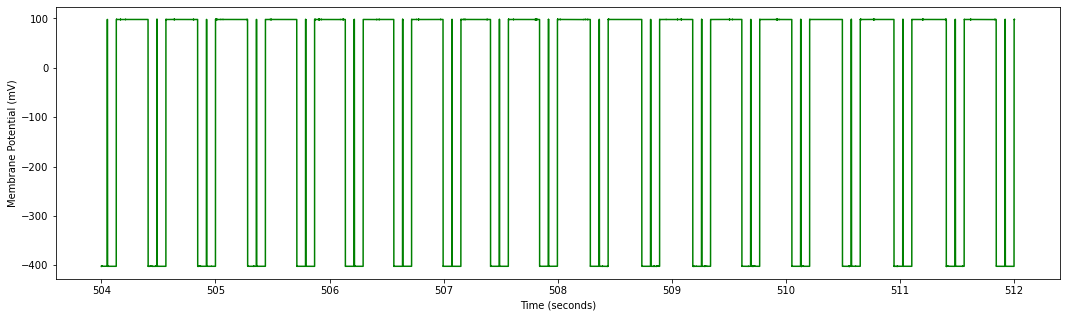

Time: 12800000 ~ 13000050
Close point found: 0
Far point found: 0


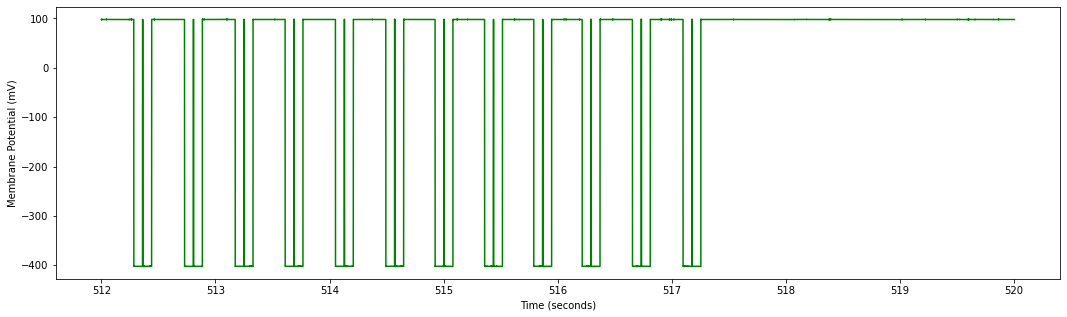

Time: 13000000 ~ 13200050
Close point found: 0
Far point found: 0


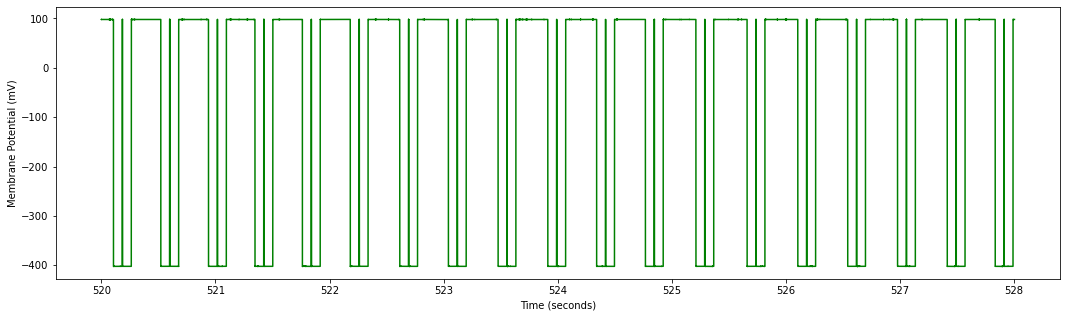

Time: 13200000 ~ 13400050
Close point found: 0
Far point found: 0


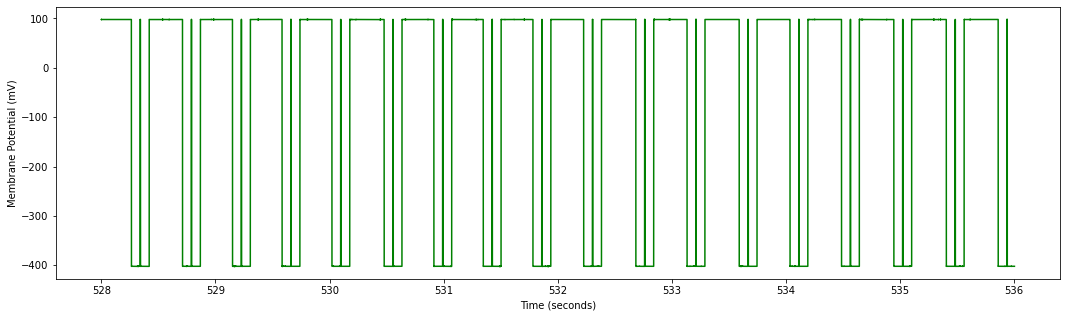

Time: 13400000 ~ 13600050
Close point found: 0
Far point found: 0


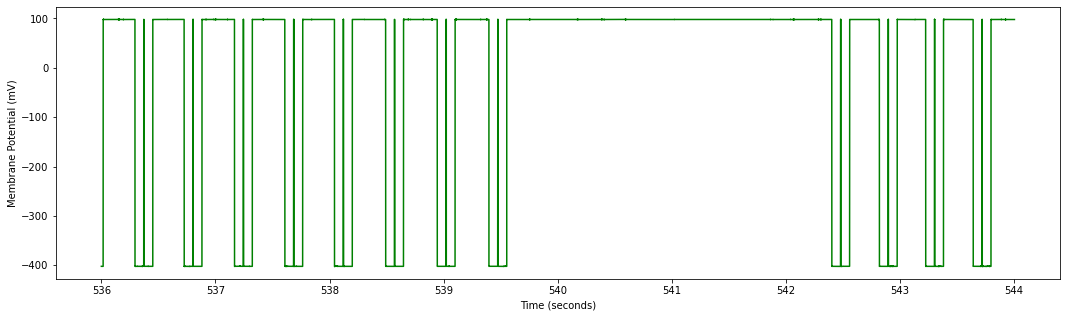

Time: 13600000 ~ 13800050
Close point found: 0
Far point found: 0


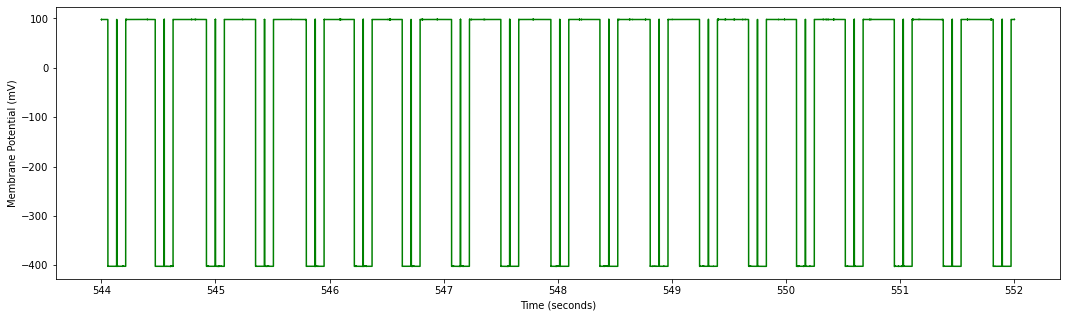

Time: 13800000 ~ 14000050
Close point found: 0
Far point found: 0


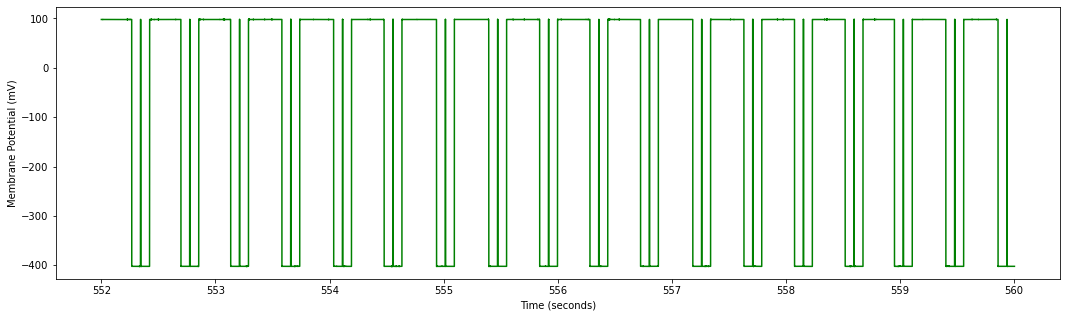

Time: 14000000 ~ 14200050
Close point found: 0
Far point found: 0


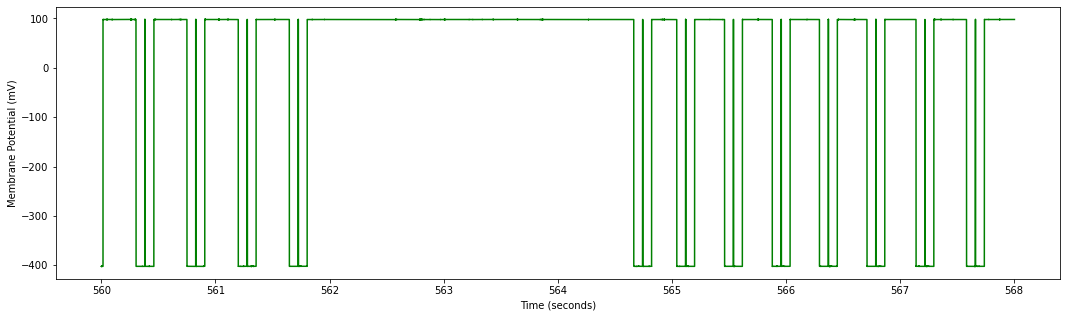

Time: 14200000 ~ 14400050
Close point found: 0
Far point found: 0


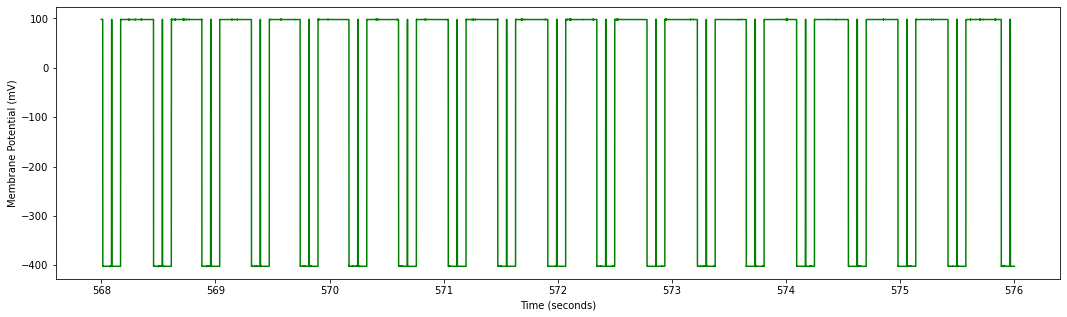

Time: 14400000 ~ 14600050
Close point found: 0
Far point found: 0


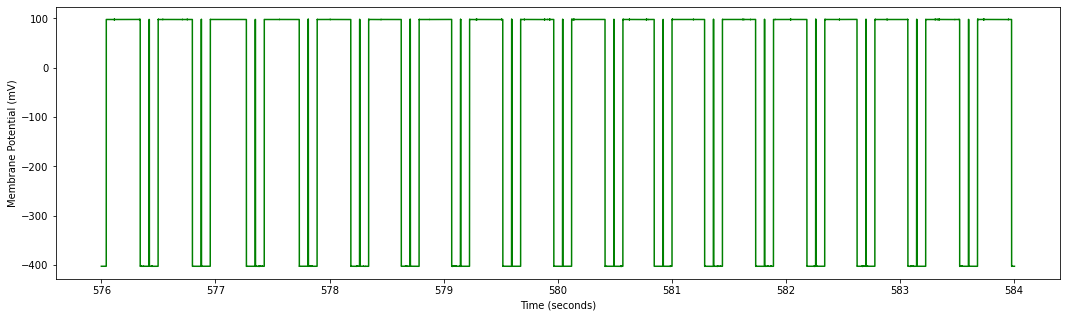

Time: 14600000 ~ 14800050
Close point found: 0
Far point found: 0


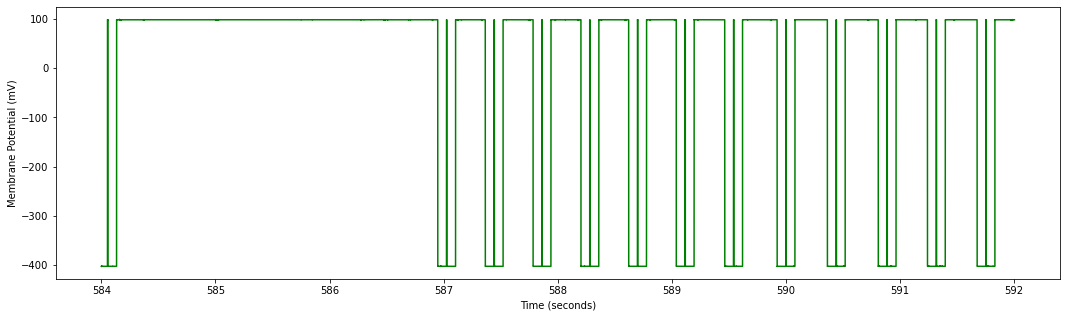

Time: 14800000 ~ 15000050
Close point found: 0
Far point found: 0


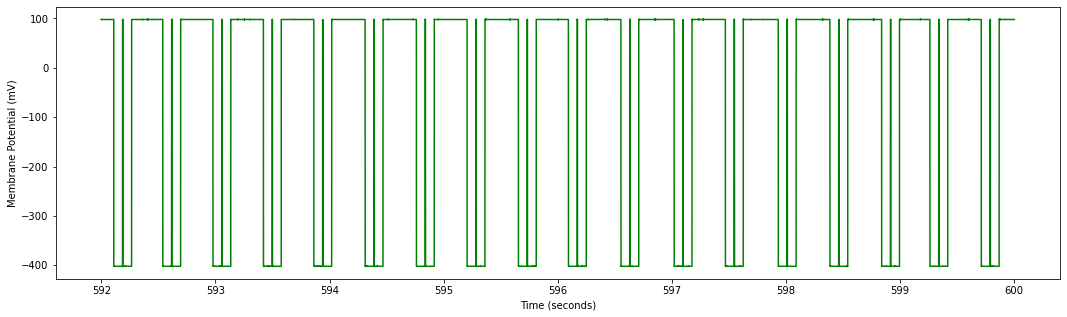

Time: 15000000 ~ 15200050
Close point found: 0
Far point found: 0


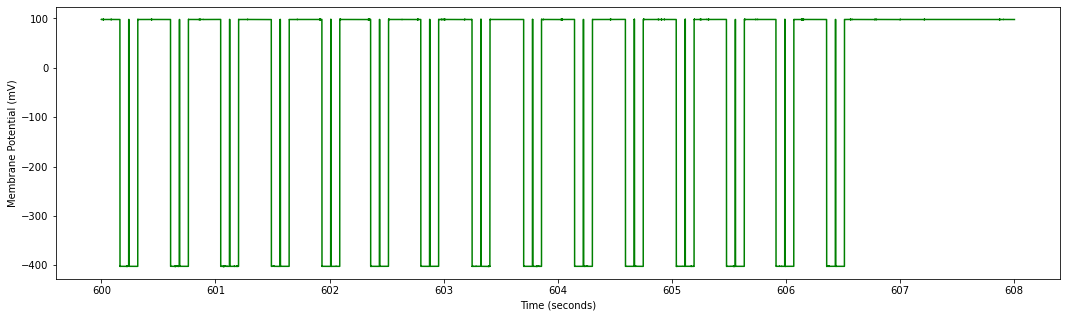

Time: 15200000 ~ 15400050
Close point found: 0
Far point found: 0


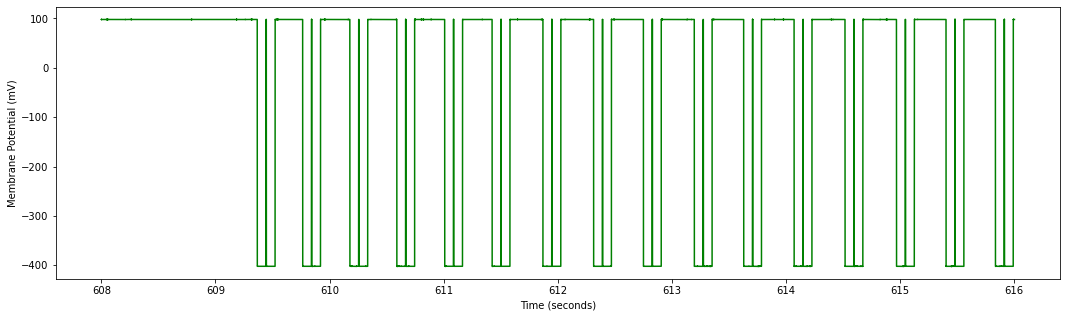

Time: 15400000 ~ 15600050
Close point found: 0
Far point found: 0


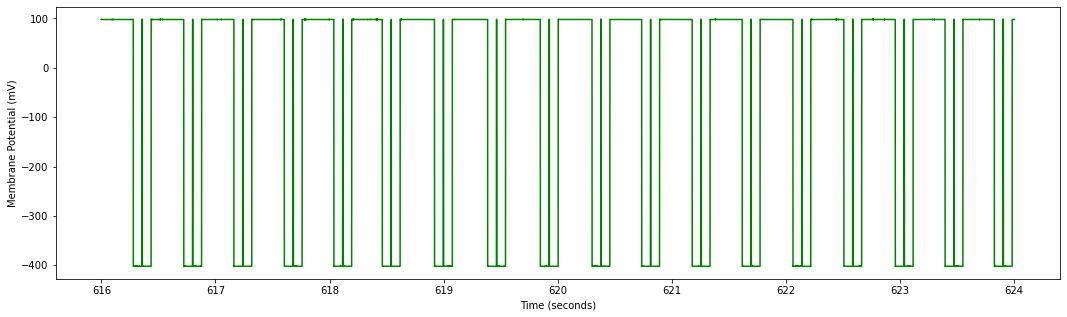

Time: 15600000 ~ 15800050
Close point found: 0
Far point found: 0


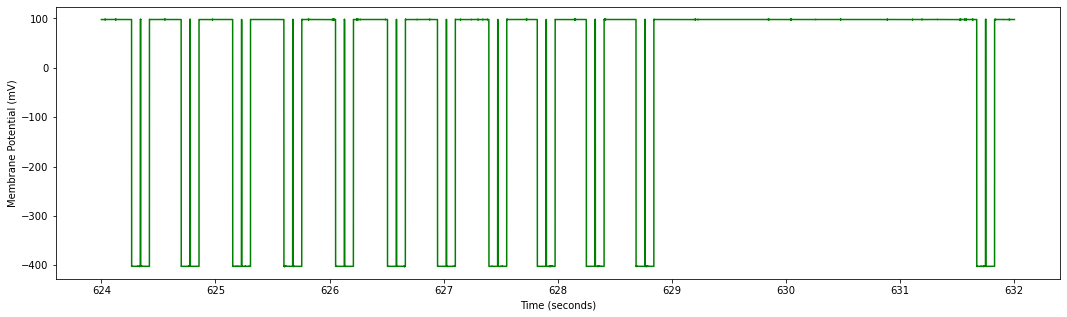

Time: 15800000 ~ 16000050
Close point found: 0
Far point found: 0


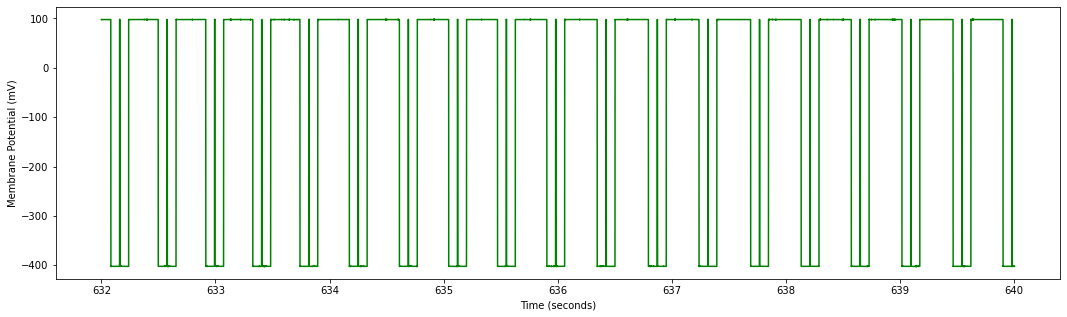

Time: 16000000 ~ 16200050
Close point found: 0
Far point found: 0


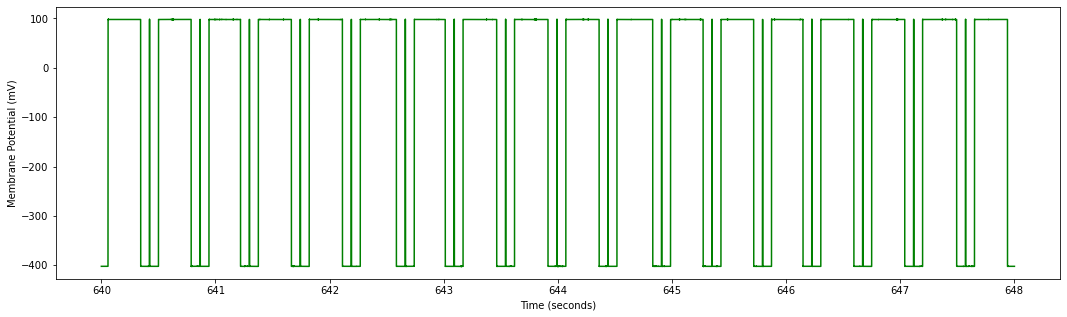

Time: 16200000 ~ 16400050
Close point found: 0
Far point found: 0


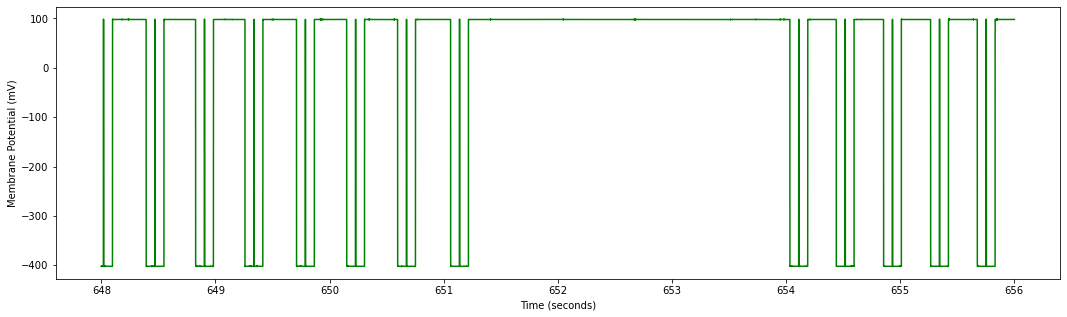

Time: 16400000 ~ 16600050
Close point found: 0
Far point found: 0


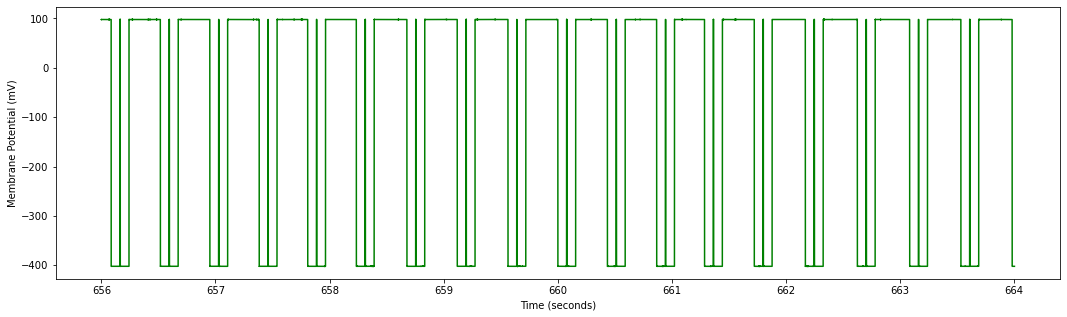

Time: 16600000 ~ 16800050
Close point found: 0
Far point found: 0


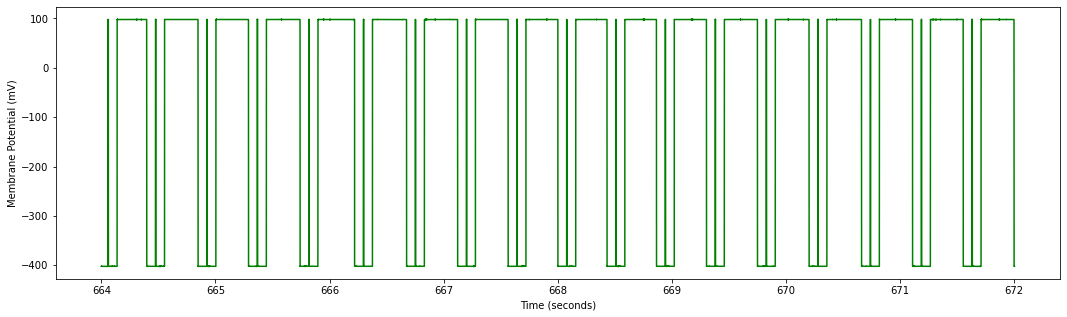

Time: 16800000 ~ 17000050
Close point found: 0
Far point found: 0


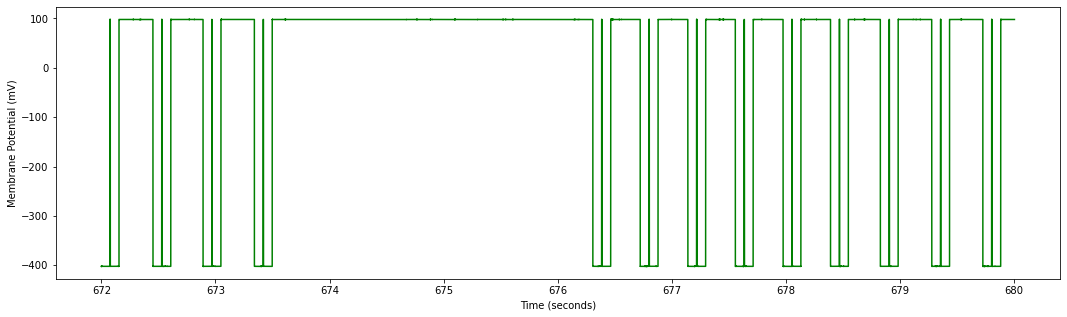

Time: 17000000 ~ 17200050
Close point found: 0
Far point found: 0


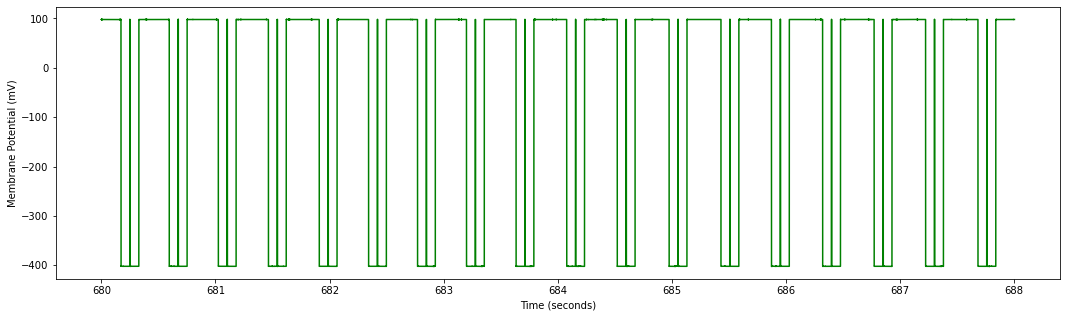

Time: 17200000 ~ 17400050
Close point found: 0
Far point found: 0


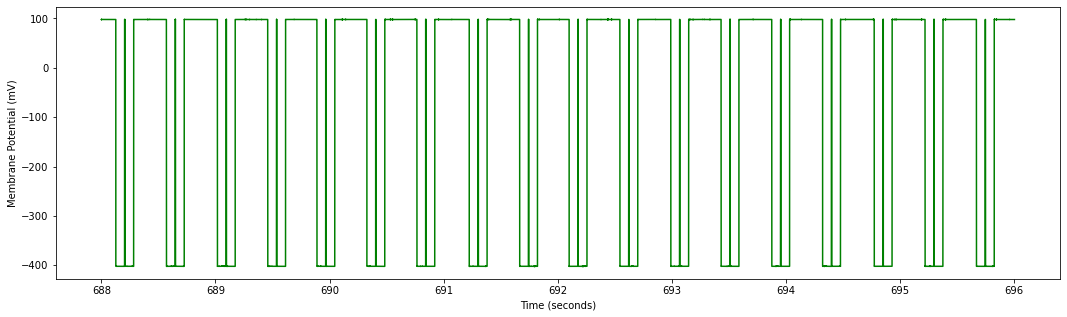

Time: 17400000 ~ 17600050
Close point found: 0
Far point found: 0


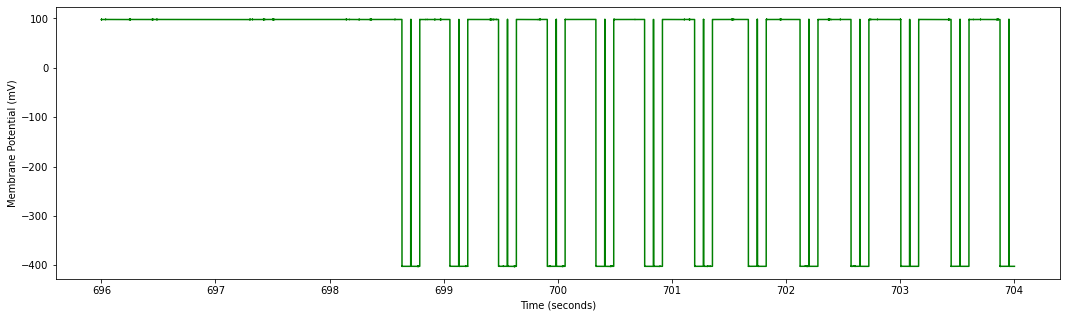

Time: 17600000 ~ 17800050
Close point found: 0
Far point found: 0


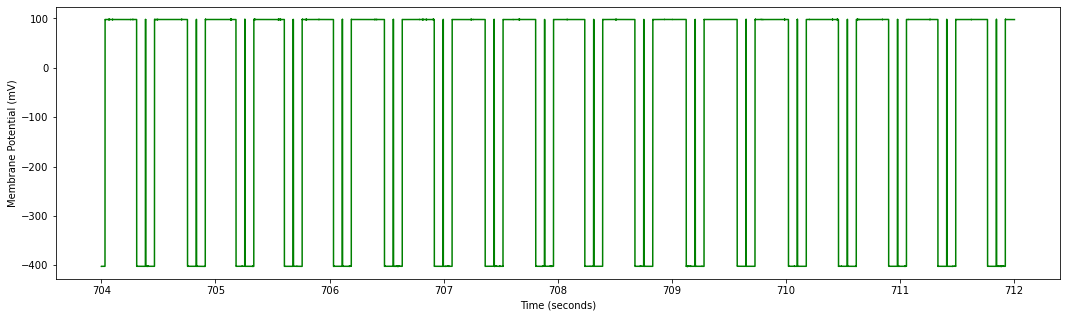

Time: 17800000 ~ 18000050
Close point found: 0
Far point found: 0


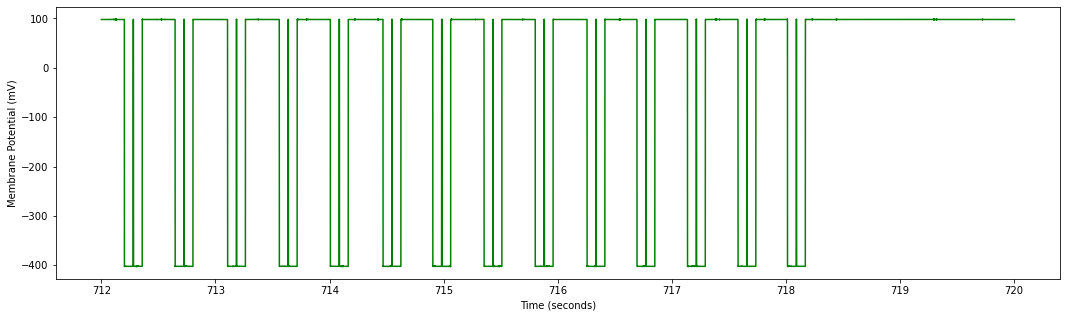

Time: 18000000 ~ 18200050
Close point found: 0
Far point found: 0


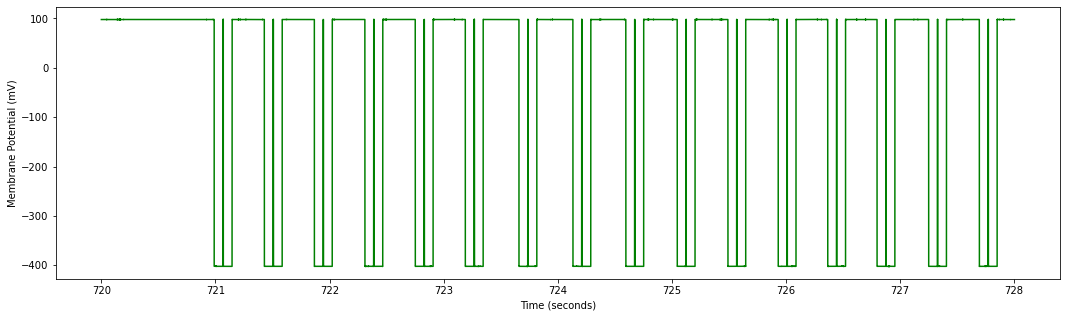

Time: 18200000 ~ 18400050
Close point found: 0
Far point found: 0


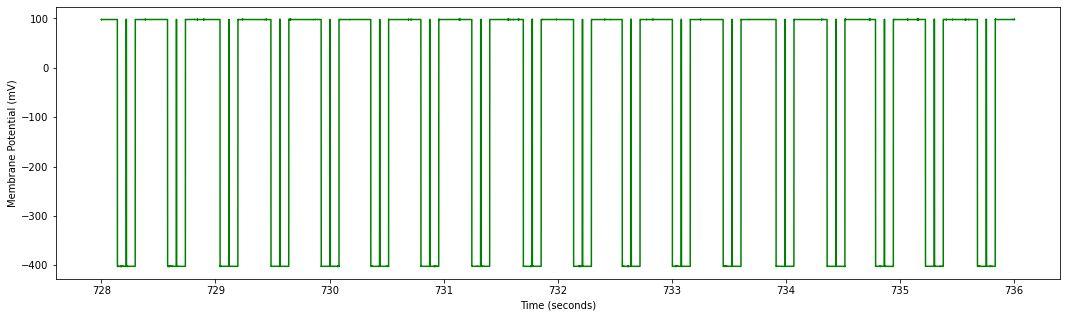

Time: 18400000 ~ 18600050
Close point found: 0
Far point found: 0


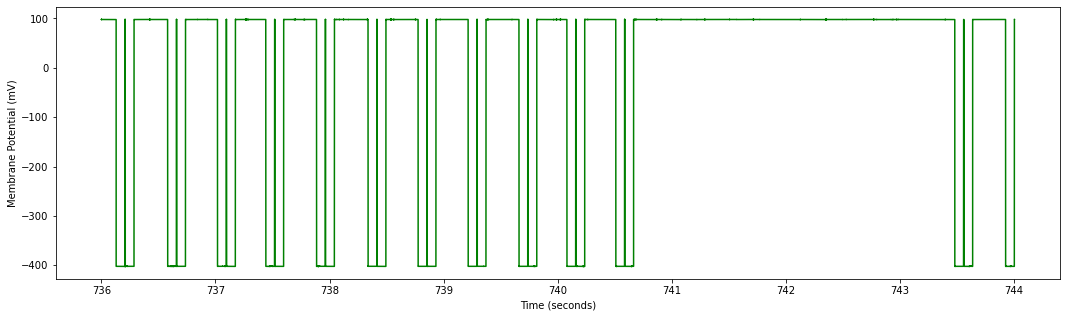

Time: 18600000 ~ 18800050
Close point found: 0
Far point found: 0


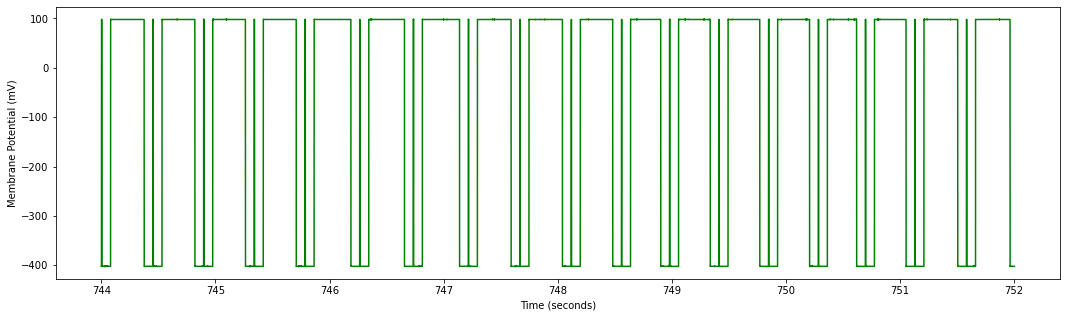

Time: 18800000 ~ 19000050
Close point found: 0
Far point found: 0


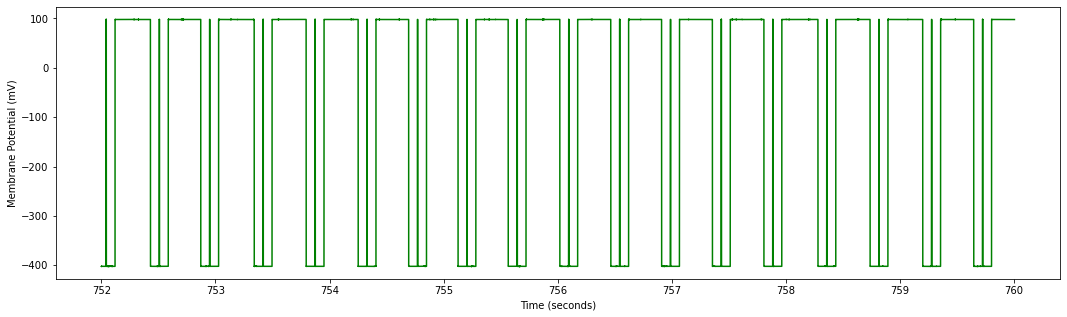

Time: 19000000 ~ 19200050
Close point found: 0
Far point found: 0


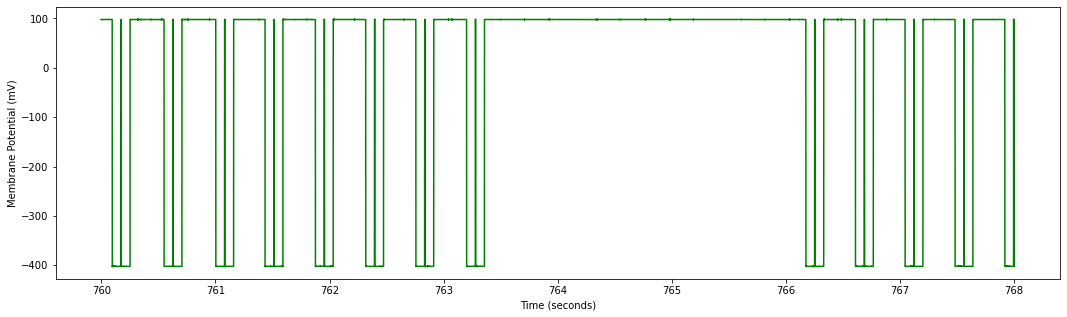

Time: 19200000 ~ 19400050
Close point found: 0
Far point found: 0


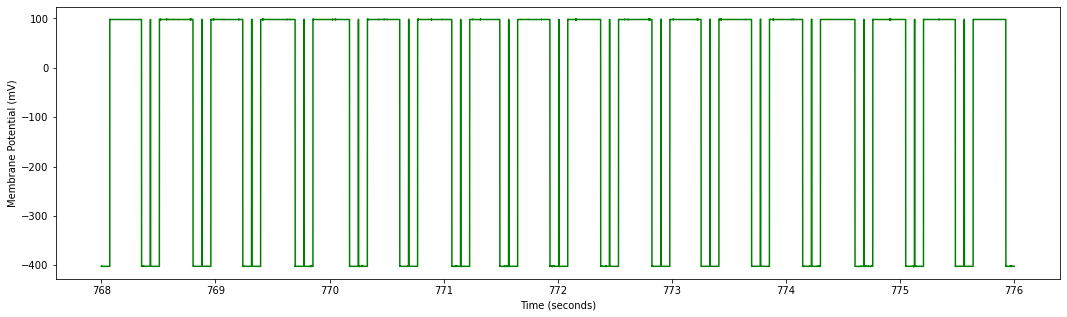

Time: 19400000 ~ 19600050
Close point found: 0
Far point found: 0


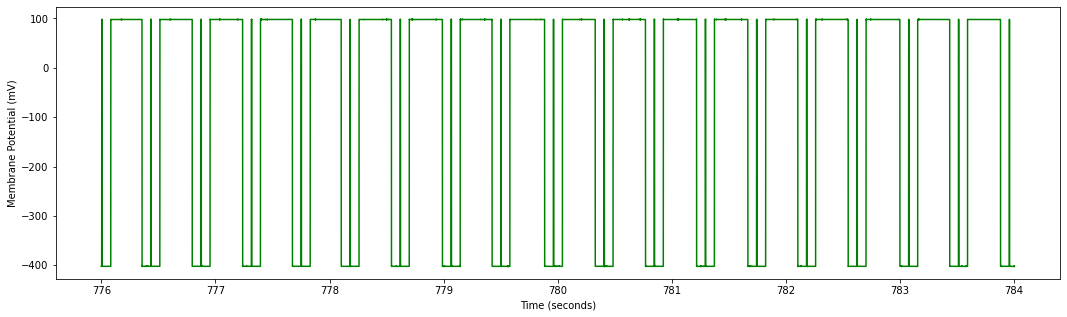

Time: 19600000 ~ 19800050
Close point found: 0
Far point found: 0


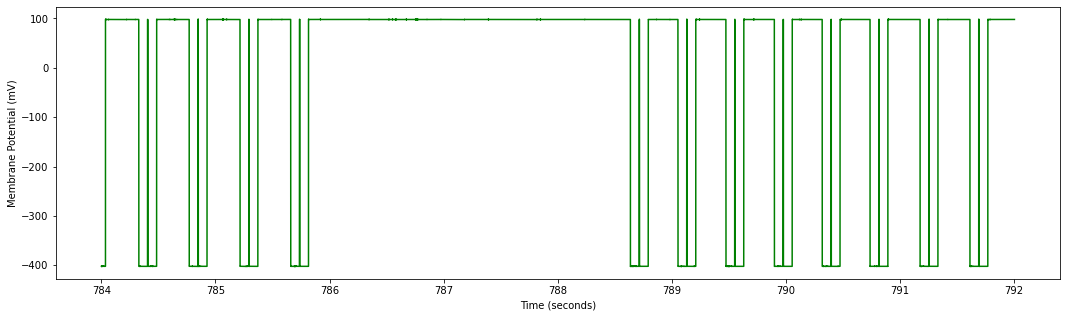

Time: 19800000 ~ 20000050
Close point found: 0
Far point found: 0


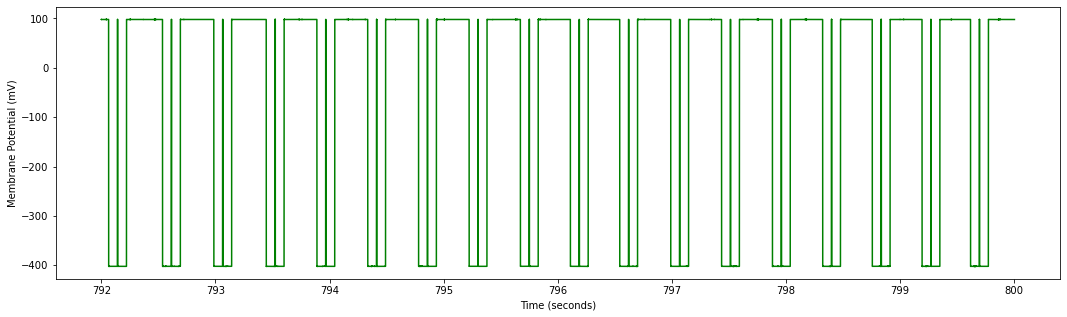

Time: 20000000 ~ 20200050
Close point found: 0
Far point found: 0


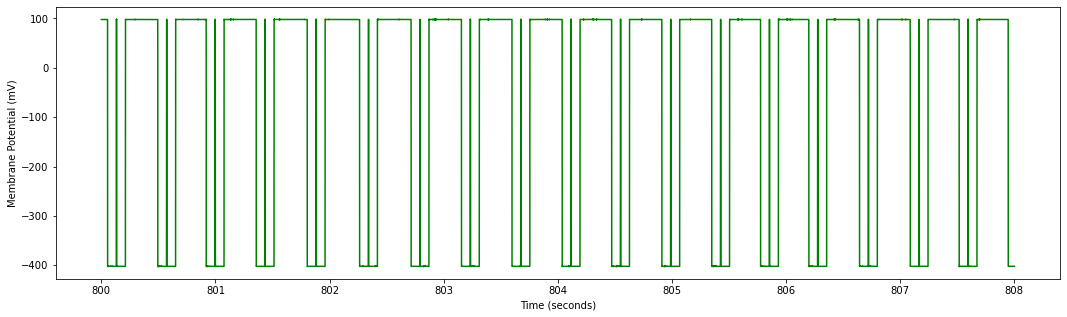

Time: 20200000 ~ 20400050
Close point found: 0
Far point found: 0


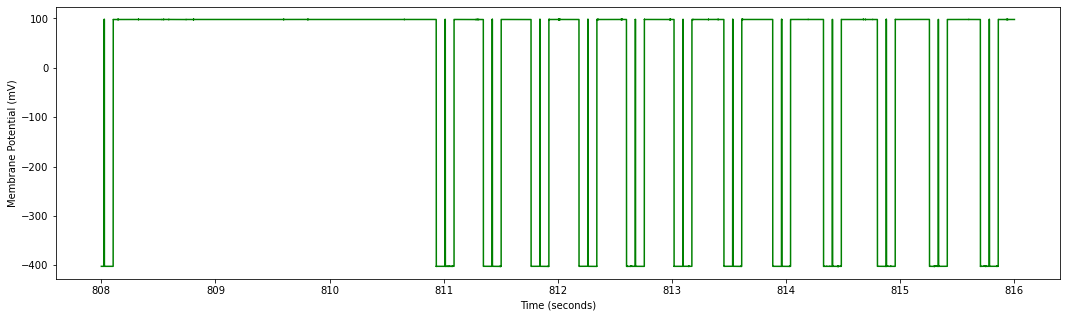

Time: 20400000 ~ 20600050
Close point found: 0
Far point found: 0


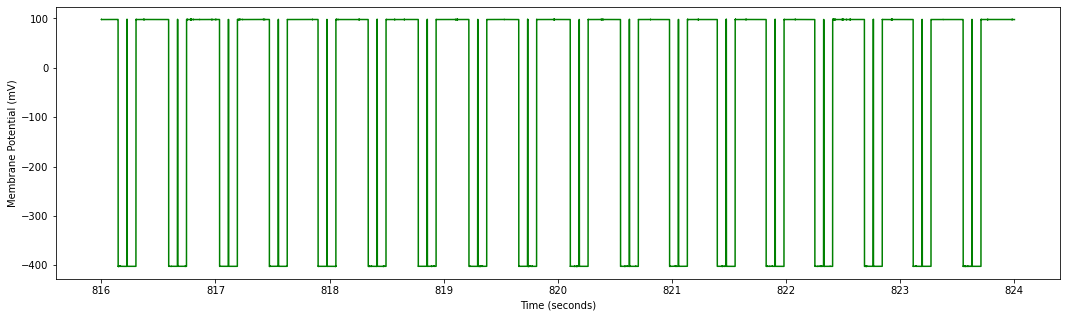

Time: 20600000 ~ 20800050
Close point found: 0
Far point found: 0


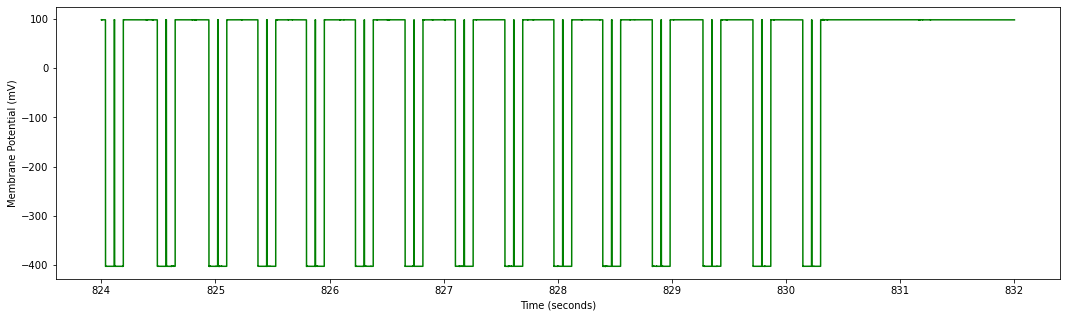

Time: 20800000 ~ 21000050
Close point found: 0
Far point found: 0


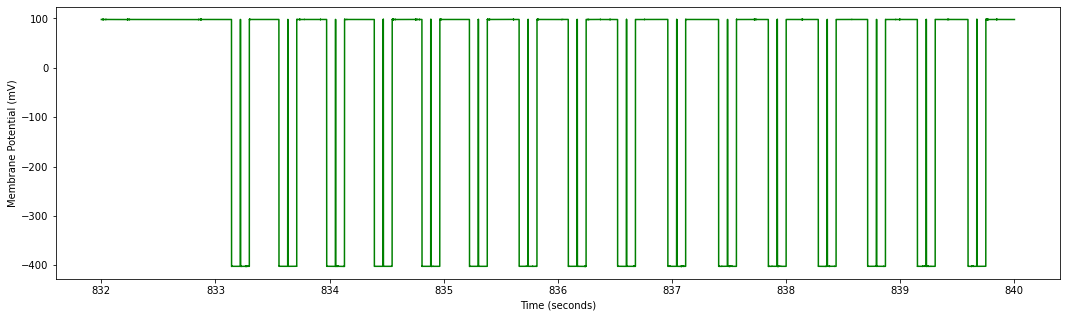

Time: 21000000 ~ 21200050
Close point found: 0
Far point found: 0


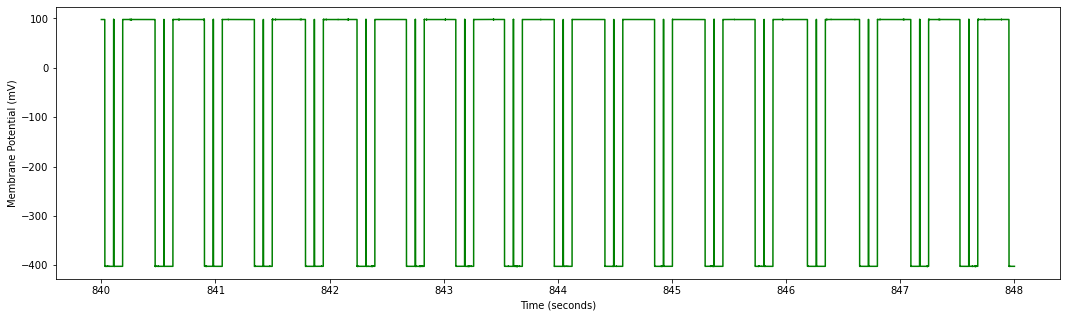

Time: 21200000 ~ 21400050
Close point found: 0
Far point found: 0


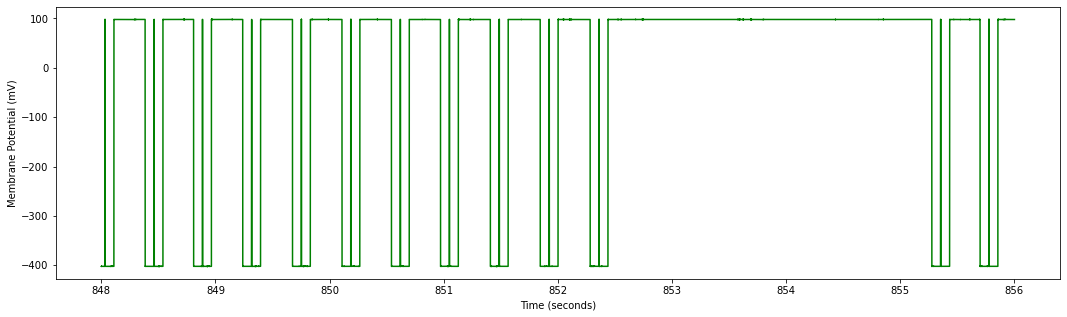

Time: 21400000 ~ 21600050
Close point found: 0
Far point found: 0


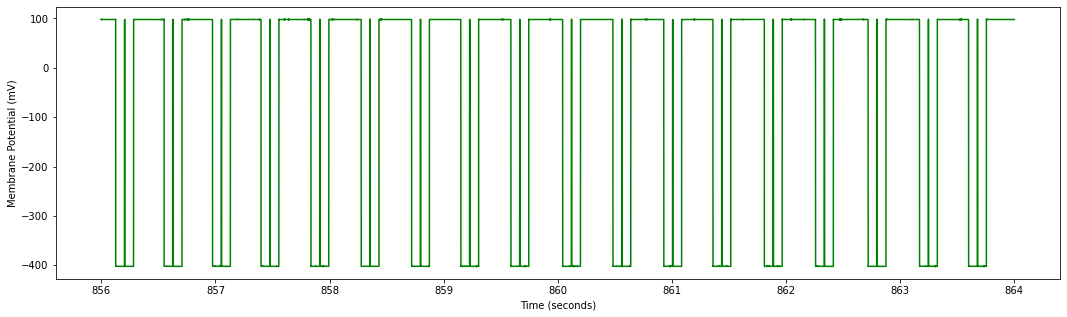

Time: 21600000 ~ 21800050
Close point found: 0
Far point found: 0


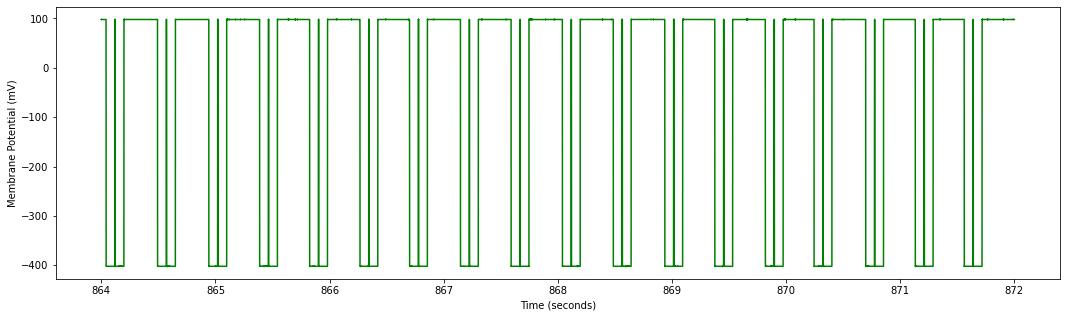

Time: 21800000 ~ 22000050
Close point found: 0
Far point found: 0


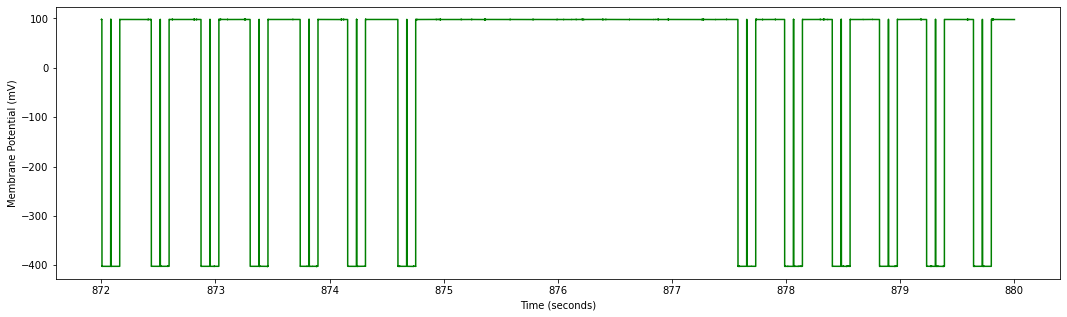

Time: 22000000 ~ 22200050
Close point found: 0
Far point found: 0


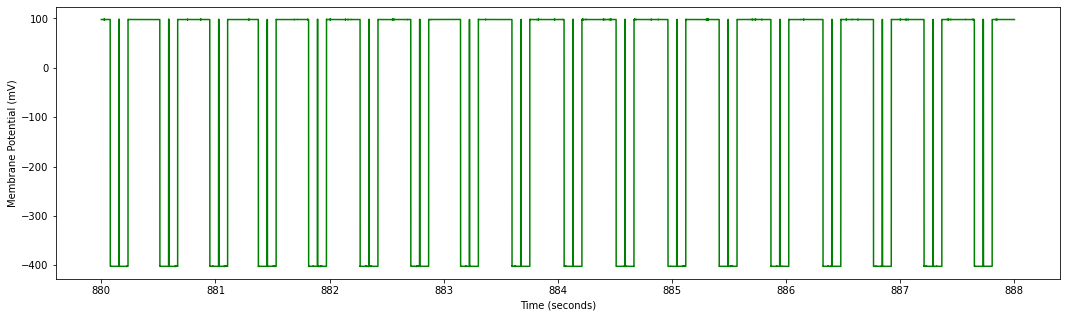

Time: 22200000 ~ 22400050
Close point found: 0
Far point found: 0


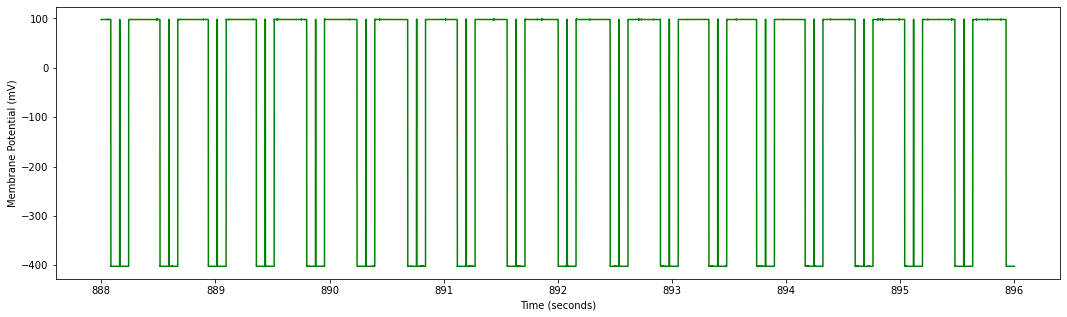

Time: 22400000 ~ 22600050
Close point found: 0
Far point found: 0


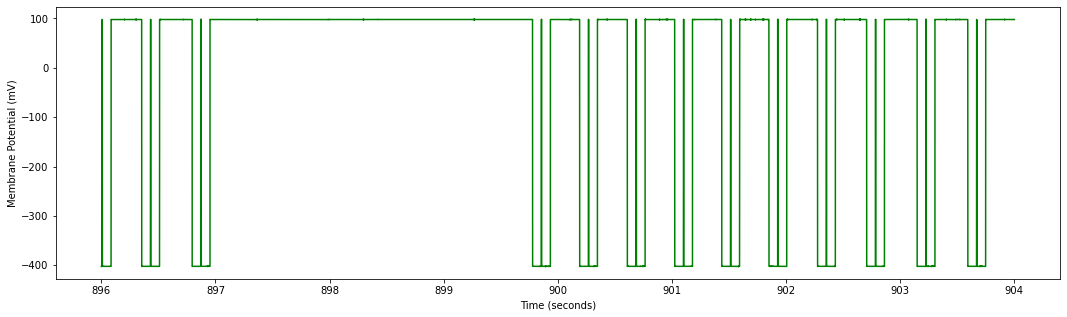

Time: 22600000 ~ 22800050
Close point found: 0
Far point found: 0


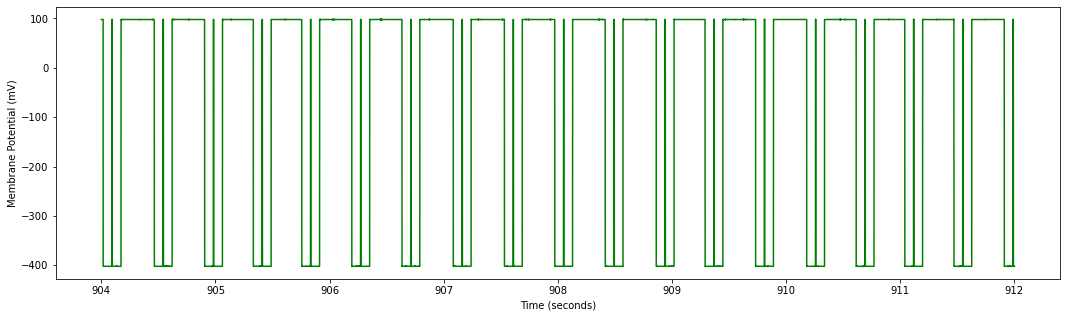

Time: 22800000 ~ 23000050
Close point found: 0
Far point found: 0


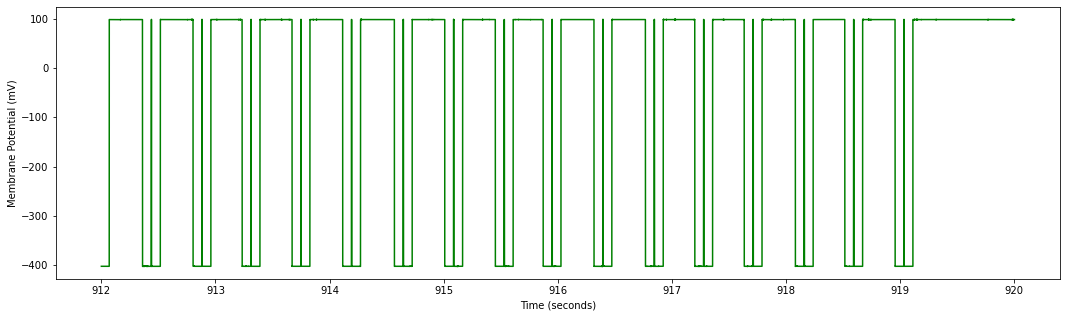

Time: 23000000 ~ 23200050
Close point found: 0
Far point found: 0


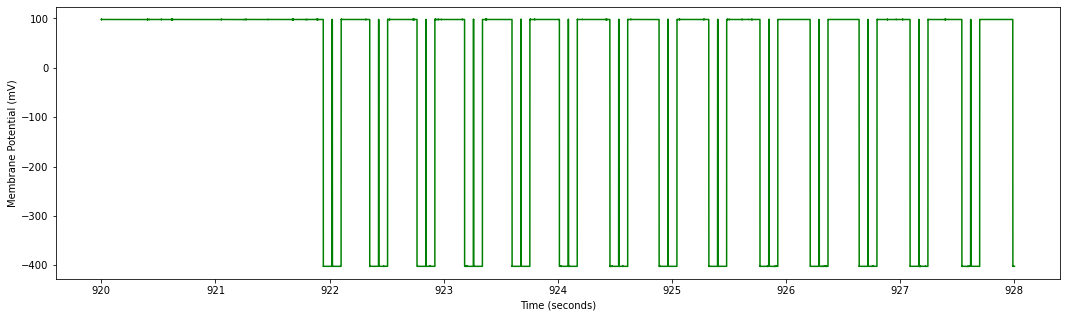

Time: 23200000 ~ 23400050
Close point found: 0
Far point found: 0


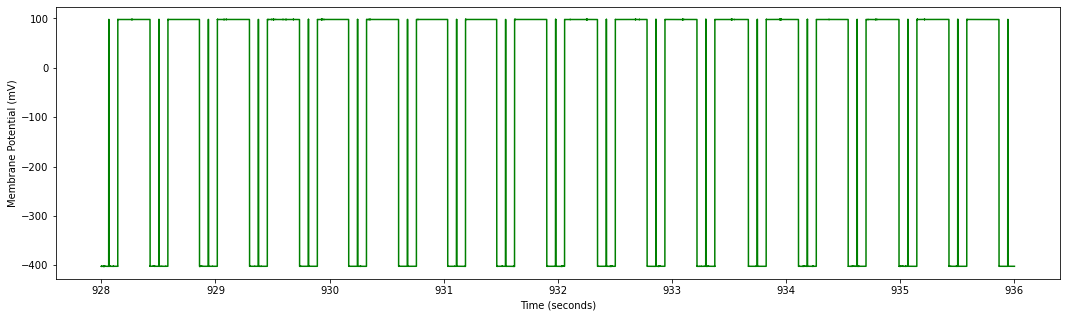

Time: 23400000 ~ 23600050
Close point found: 0
Far point found: 0


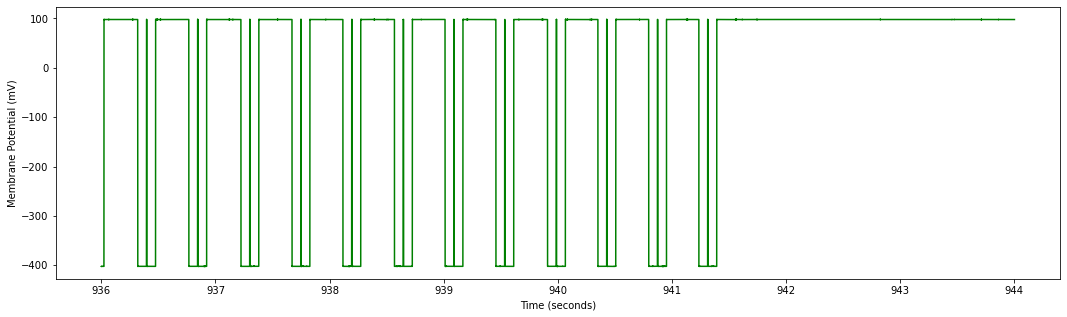

Time: 23600000 ~ 23800050
Close point found: 0
Far point found: 0


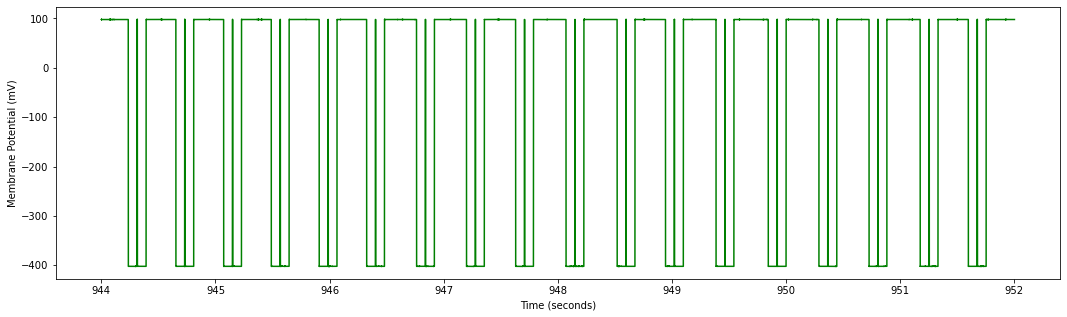

Time: 23800000 ~ 24000050
Close point found: 0
Far point found: 0


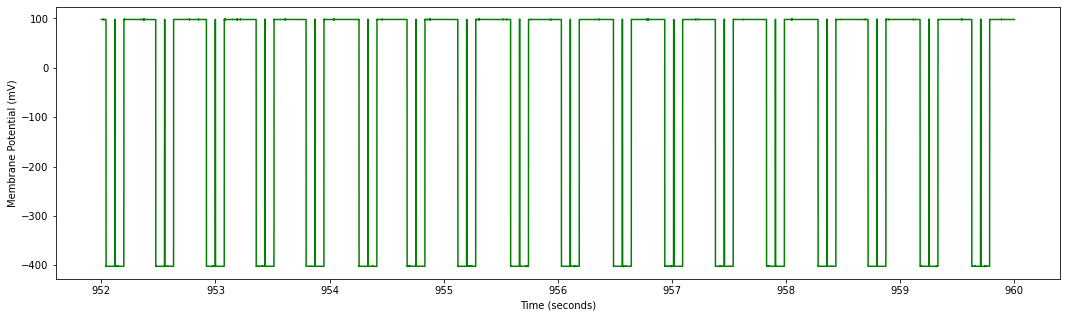

Time: 24000000 ~ 24200050
Close point found: 0
Far point found: 0


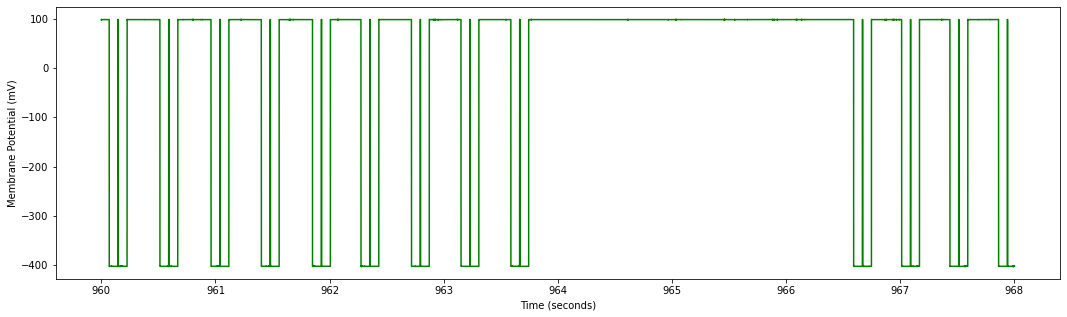

Time: 24200000 ~ 24400050
Close point found: 0
Far point found: 0


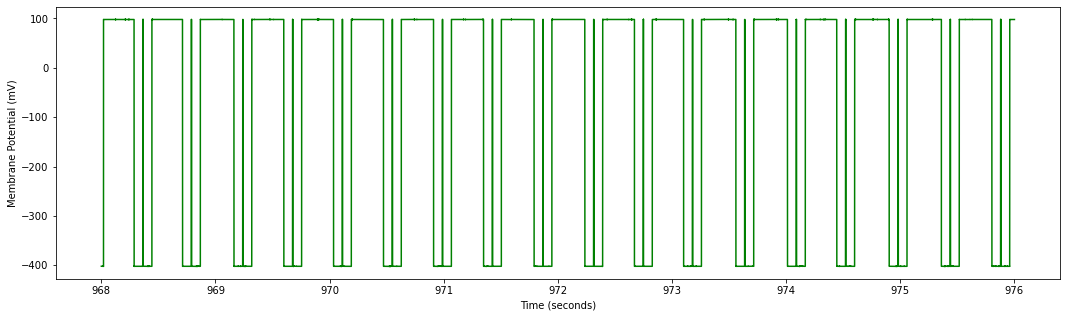

Time: 24400000 ~ 24600050
Close point found: 0
Far point found: 0


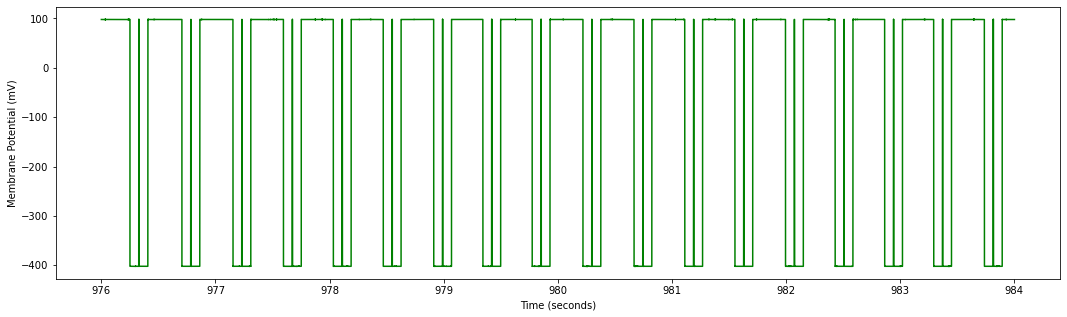

Time: 24600000 ~ 24800050
Close point found: 0
Far point found: 0


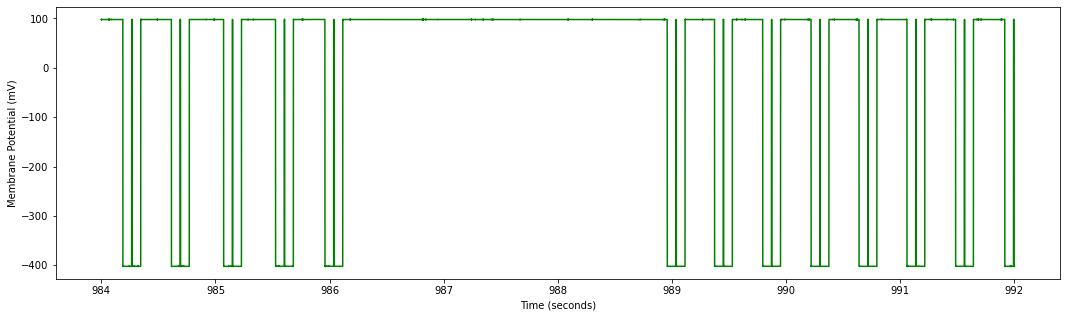

Time: 24800000 ~ 25000050
Close point found: 0
Far point found: 0


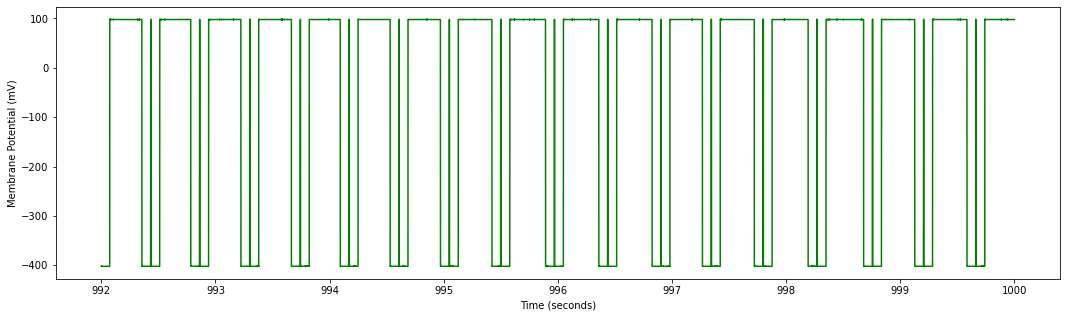

Time: 25000000 ~ 25200050
Close point found: 0
Far point found: 0


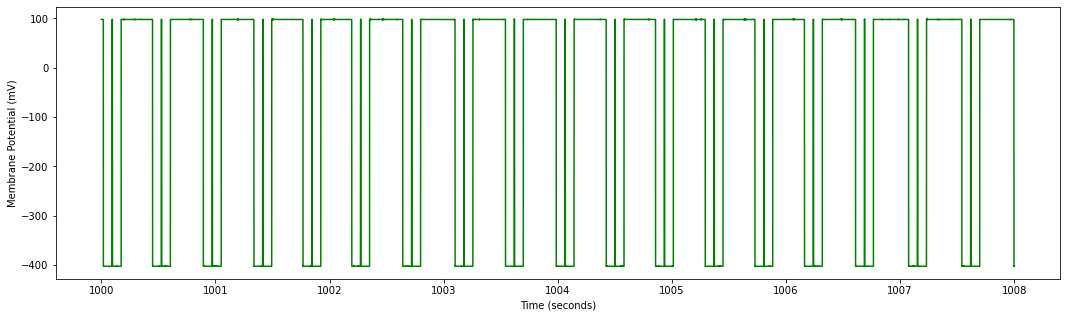

Time: 25200000 ~ 25400050
Close point found: 0
Far point found: 0


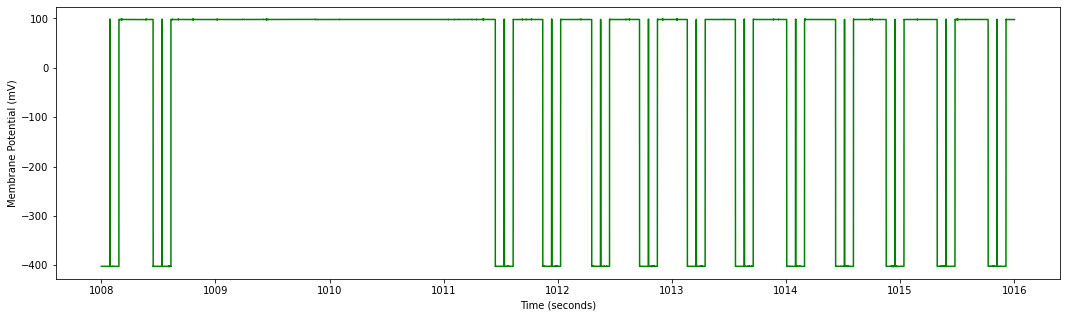

Time: 25400000 ~ 25600050
Close point found: 0
Far point found: 0


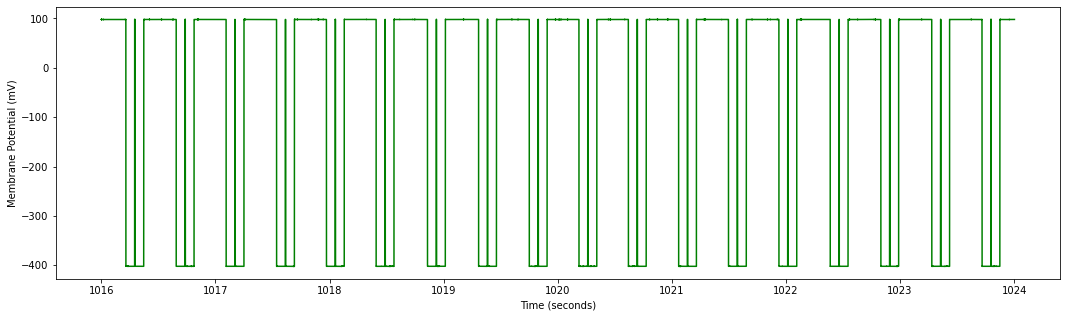

Time: 25600000 ~ 25800050
Close point found: 0
Far point found: 0


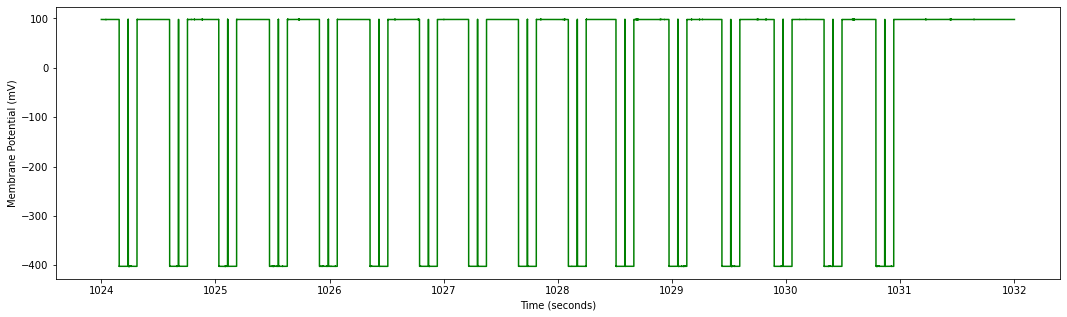

Time: 25800000 ~ 26000050
Close point found: 0
Far point found: 0


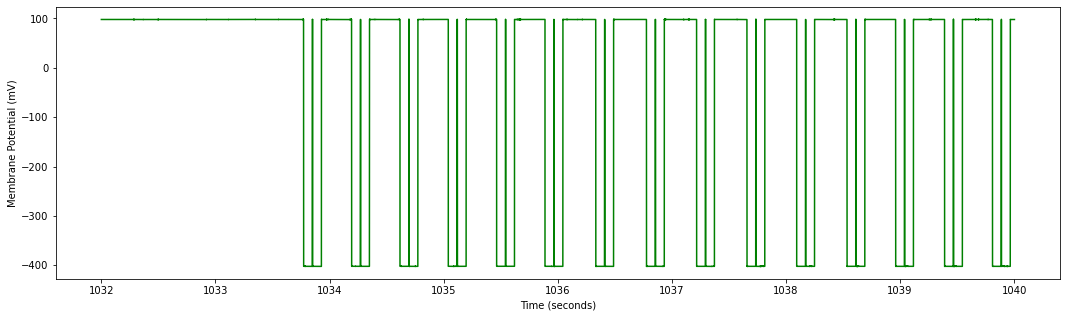

Time: 26000000 ~ 26200050
Close point found: 0
Far point found: 0


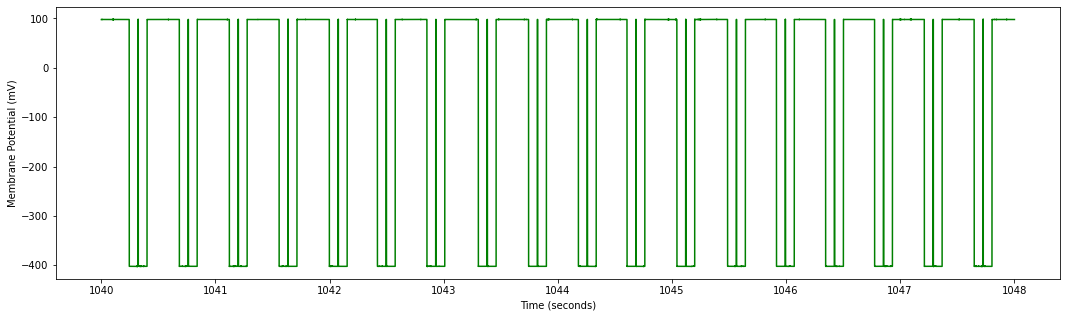

Time: 26200000 ~ 26400050
Close point found: 0
Far point found: 0


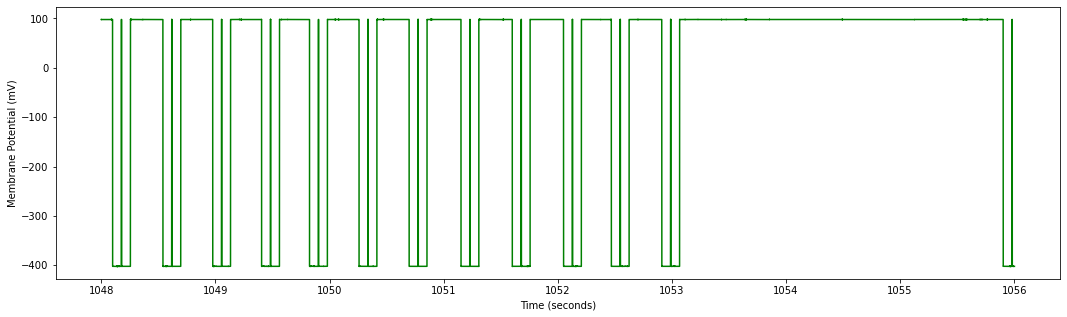

Time: 26400000 ~ 26600050
Close point found: 0
Far point found: 0


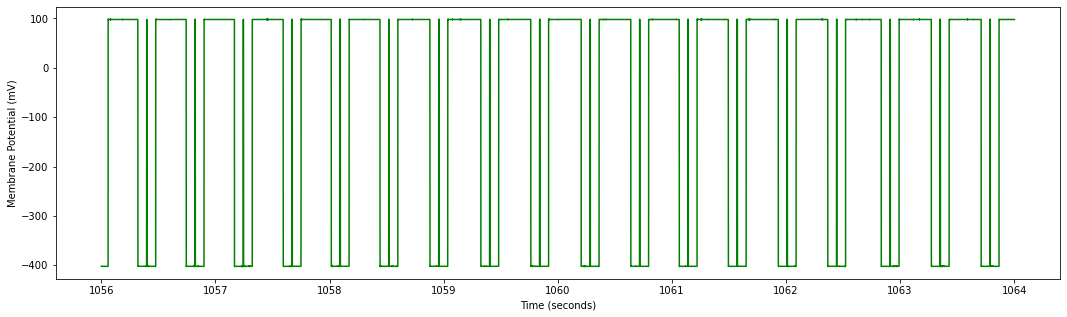

Time: 26600000 ~ 26800050
Close point found: 0
Far point found: 0


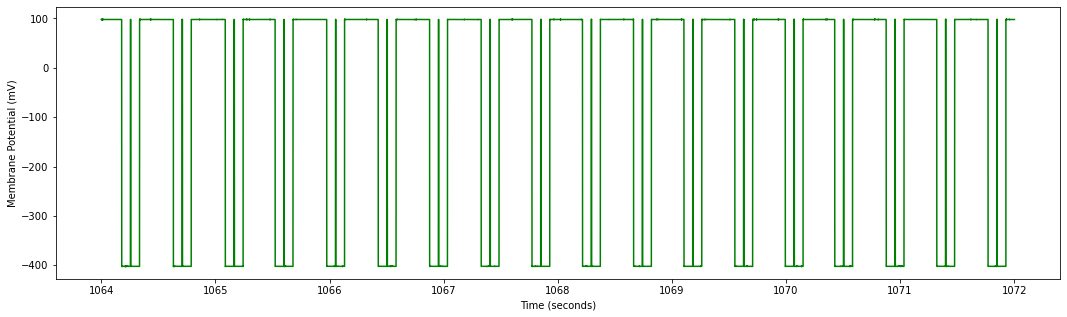

Time: 26800000 ~ 27000050
Close point found: 0
Far point found: 0


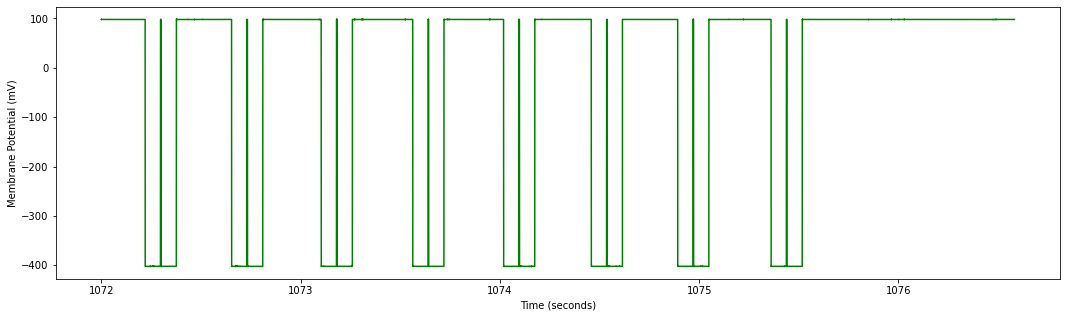

In [13]:
interval = 200000
for i in range(0,len(abf.sweepY),interval):
    print("Time: %d ~ %d"%(i,i+interval+50))
    timeStart = i
    timeEnd = i+interval+50
    close_qty,far_qty = plot_v2(abf,volt,timeStart = timeStart, timeEnd = timeEnd,channel = 4)
    

## Test 03_v3--Check Total Points Collected in each (x,y)

In [41]:
print_points_qty(abf,end_index)

75 120 48 
17 20 8  
17 20 8  
17 20 8  
17 20 8  
17 20 8  
17 20 8  
17 20 8  
17 20 8  
17 20 8  
17 20 8  
17 20 8  
17 20 8  
17 20 8  
17 20 8  
17 20 8  
17 20 8  
17 20 8  
17 20 8  
17 20 8  
17 20 8  
17 20 8  
17 20 8  
17 20 8  
17 20 8  
17 20 8  
17 20 8  
17 20 8  
17 20 8  
17 20 8  
17 20 8  
17 20 8  
17 20 8  
17 20 8  
17 20 8  
17 20 8  
17 20 8  
17 20 8  
17 20 8  
17 20 8  
Total points: 1998


# Start

##### V2: Include Bias
* 800mV 22214004.abf: 3120 + 4(start) + 3(end) = 3127
* 700mV 22214005.abf: 3120 + 6(start) = 3126
* 200mV 22318006.abf: 3120 + 5(start) = 3125
* 500mV 22304010.abf:
* 200mV 22323007.abf: 3120 + 
* 200mV 22504024.abf: 3120 + 12(start) = 3132
* 600mV 22519010.abf: 3120 + 3(start)= 3123 #Care for time: 36818519 36818524
### V1: Not include Bias

* 800mV 21n05000.abf: 3120 + 4(start) = 3124
* 700mV 21n05001.abf: 3120 + 4(start) + 41(end) = 3165 
* 600mV 21n05002.abf: 3120 + 4(start) = 3124
* 500mV 21n05003.abf: 3120 + 6(start) + 21(end) = 3147
* 400mV 21n05004.abf: Last point have only close, 3120+5(start)+1(end) = 3126
* 300mV 21n05005.abf: 3120 + 4(start) + 39(end) = 3163
* 600mV 21930014.abf: 3120 + 5(start)  = 3125
* 800mV 21d04000.abf: 3120 + 6(start) + 30(end) =3156

In [35]:
# v2
abfFile = "22908013.abf"
abf = pyabf.ABF("abf\\"+abfFile)

In [87]:
bins = 50
# start_ignore and end_ignore: extra points before reshape into rows
# start_extra and end_extra: extra points of each rows
start_ignore = 3 #Don't include the single point
end_ignore = 0  #Don't include the single point
pqty = 20
start_extra = 5
end_extra = 0
volt = -400 
title_prefix = str(volt)+"mV"
fig_save_path =getcwd()+"\\result\\"
Row = 40
Col = 40
start_single = False
end_single = False
emf_bias = 0
current_bias = 0

In [70]:
close,far,close_index,end_index = findStable_Bias(abf,volt,start_single=start_single,end_single=end_single)

Close point found: 1998
Far point found: 1998


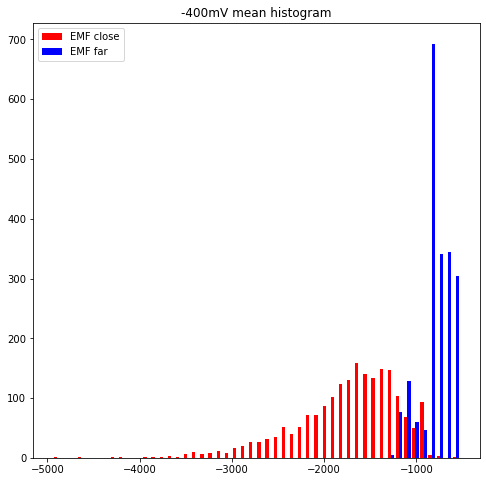

In [71]:
plt.figure()
plt.hist((close,far),bins=bins,label = ('EMF close','EMF far'),color = ('red','blue'))
plt.legend()
plt.title("%s mean histogram"%(title_prefix))
plt.savefig("%s mean histogram"%(title_prefix))
plt.show()

In [72]:
aut_close,quartz_close = separate(close,Row = Row, Col = Col,pqty = pqty,start_ignore = start_ignore, end_ignore = end_ignore, start_extra = start_extra, end_extra = end_extra,bias = emf_bias)
aut_far,quartz_far = separate(far,Row = Row, Col = Col,pqty = pqty,start_ignore = start_ignore, end_ignore = end_ignore,start_extra = start_extra, end_extra = end_extra,bias = emf_bias)

243 None
243 None


In [73]:
print("AUT Close:%.2f QUARTZ Close:%.2f"%(np.mean(aut_close),np.mean(quartz_close)))
print("AUT Far:%.2f QUARTZ Far:%.2f"%(np.mean(aut_far),np.mean(quartz_far)))

AUT Close:-1828.59 QUARTZ Close:-1799.42
AUT Far:-780.33 QUARTZ Far:-785.05


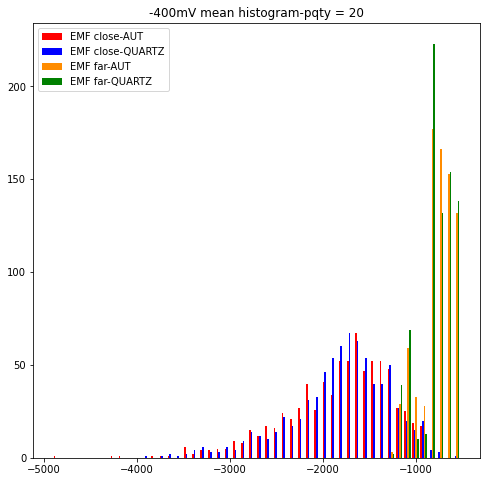

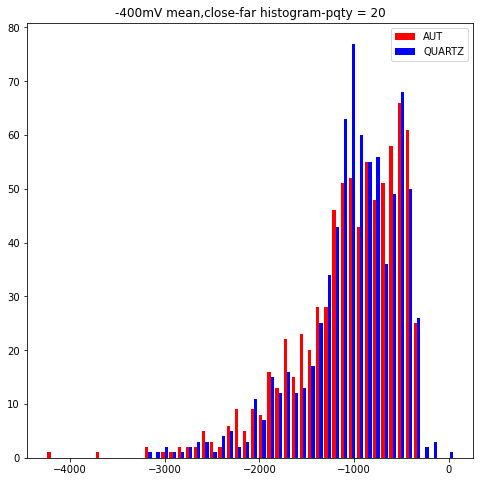

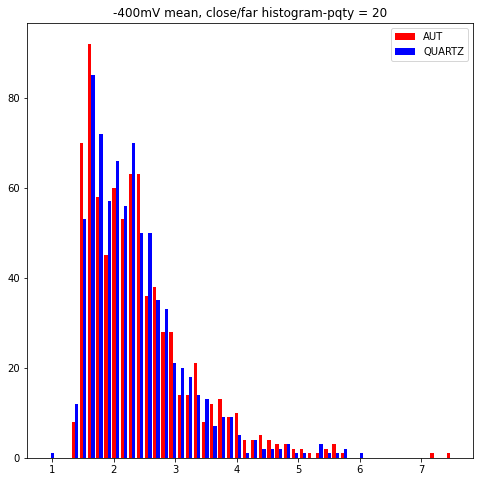

In [74]:
plt.figure()
plt.hist((aut_close,quartz_close,aut_far,quartz_far),bins=bins,label = ('EMF close-AUT','EMF close-QUARTZ','EMF far-AUT','EMF far-QUARTZ'),color = ('red','blue','darkorange','green'))
plt.legend()
plt.title("%s mean histogram-pqty = %d"%(title_prefix,pqty))
plt.savefig(fig_save_path+title_prefix+" mean histogram-pqty = "+str(pqty))
plt.show()

plt.figure()
plt.hist((aut_close-aut_far,quartz_close-quartz_far),bins=bins,label = ('AUT','QUARTZ'),color = ('red','blue'))
plt.legend()
plt.title("%s mean,close-far histogram-pqty = %d"%(title_prefix,pqty))
plt.savefig(fig_save_path+title_prefix + " mean,close-far histogram-pqty = "+str(pqty))
plt.show()

plt.figure()
plt.hist((aut_close/aut_far,quartz_close/quartz_far),bins=bins,label = ('AUT','QUARTZ'),color = ('red','blue'))
plt.legend()
plt.title("%s mean, close/far histogram-pqty = %d"%(title_prefix,pqty))
plt.savefig(fig_save_path+title_prefix + "close divide far histogram-pqty = "+str(pqty))
plt.show()

AUT: 2.409064 +- 5.124325
QUARTZ: 2.345847 +- 3.627785
40 39


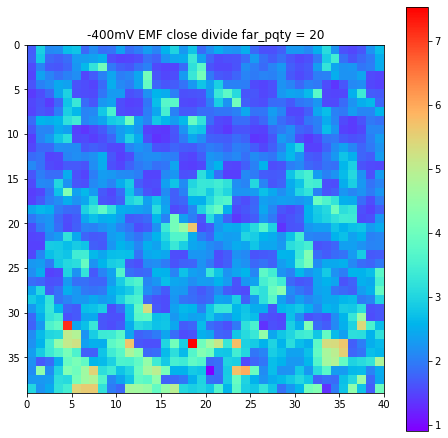

In [99]:
aut = aut_close/aut_far
quartz = quartz_close/quartz_far

a = aut
mean = np.mean(a)
Max = np.max(a)
Min = np.min(a)
print("AUT: %lf +- %lf" %(mean,max(Max-mean,mean-Min)))
a = quartz
mean = np.mean(a)
Max = np.max(a)
Min = np.min(a)
print("QUARTZ: %lf +- %lf" %(mean,max(Max-mean,mean-Min)))

aut = np.reshape(aut,(Row-1,pqty))
quartz = np.reshape(quartz,(Row-1,pqty))

EMF_normalized_data = np.hstack((aut,quartz))
plot_colormap(EMF_normalized_data,title = title_prefix + " EMF close divide far_pqty = "+str(pqty),path = fig_save_path)

AUT: -1048.263784 +- 3203.384165
QUARTZ: -1014.370885 +- 2138.644496
40 39


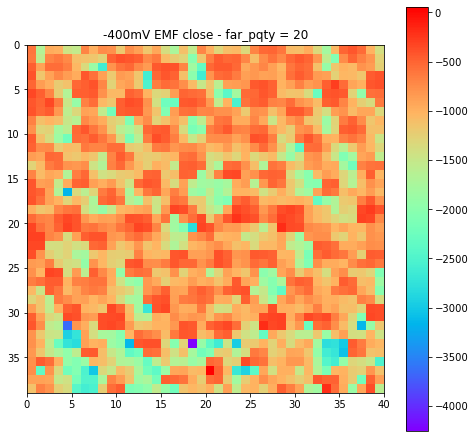

In [100]:
aut = aut_close-aut_far
quartz = quartz_close-quartz_far

a = aut
mean = np.mean(a)
Max = np.max(a)
Min = np.min(a)
print("AUT: %lf +- %lf" %(mean,max(Max-mean,mean-Min)))
a = quartz
mean = np.mean(a)
Max = np.max(a)
Min = np.min(a)
print("QUARTZ: %lf +- %lf" %(mean,max(Max-mean,mean-Min)))

aut = np.reshape(aut,(Row-1,pqty))
quartz = np.reshape(quartz,(Row-1,pqty))

EMF_normalized_data_subs = np.hstack((aut,quartz))
plot_colormap(EMF_normalized_data_subs,title = title_prefix + " EMF close - far_pqty = "+str(pqty),path = fig_save_path)

In [101]:
# Calculate on Current
I_close,I_far,_,_ = findStable_Bias(abf,volt,start_single=start_single,end_single=end_single,channel = 0)

I_aut_close,I_quartz_close = separate(I_close,Row = Row, Col = Col,pqty = pqty,start_ignore = start_ignore, end_ignore = end_ignore, start_extra = start_extra, end_extra = end_extra,bias = current_bias)
I_aut_far,I_quartz_far = separate(I_far,Row = Row, Col = Col,pqty = pqty,start_ignore = start_ignore, end_ignore = end_ignore, start_extra = start_extra, end_extra = end_extra,bias = current_bias)

Close point found: 1998
Far point found: 1998
243 None
243 None


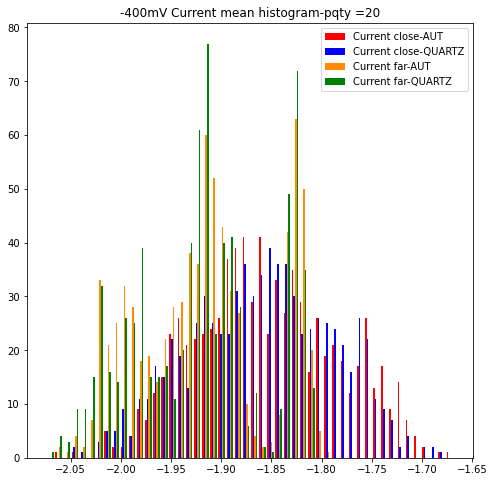

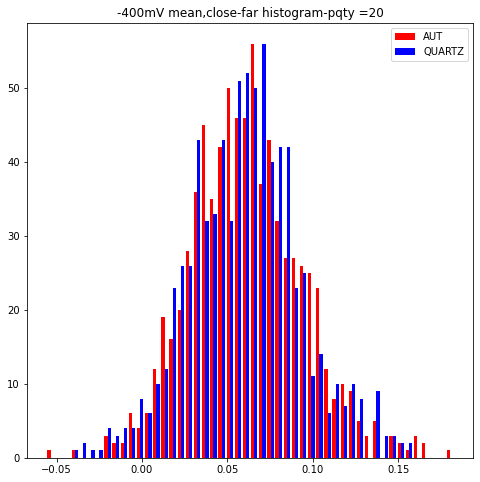

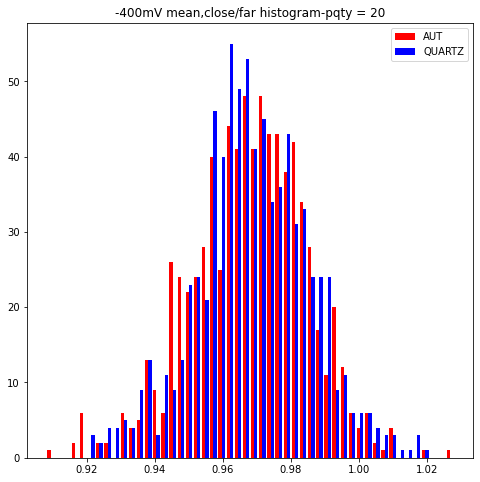

In [102]:
plt.figure()
plt.hist((I_aut_close,I_quartz_close,I_aut_far,I_quartz_far),bins=bins,label = ('Current close-AUT','Current close-QUARTZ','Current far-AUT','Current far-QUARTZ'),color = ('red','blue','darkorange','green'))
plt.legend()
plt.title(title_prefix + " Current mean histogram-pqty =" +str(pqty))
plt.savefig(fig_save_path+title_prefix + " Current mean histogram-pqty =" +str(pqty))
plt.show()

plt.figure()
plt.hist((I_aut_close-I_aut_far,I_quartz_close-I_quartz_far),bins=bins,label = ('AUT','QUARTZ'),color = ('red','blue'))
plt.legend()
plt.title(title_prefix + " mean,close-far histogram-pqty =" +str(pqty))
plt.savefig(fig_save_path+title_prefix + " mean,Current close-far histogram-pqty =" +str(pqty))
plt.show()

plt.figure()
plt.hist((I_aut_close/I_aut_far,I_quartz_close/I_quartz_far),bins=bins,label = ('AUT','QUARTZ'),color = ('red','blue'))
plt.legend()
plt.title(title_prefix + " mean,close/far histogram-pqty = "+str(pqty))
plt.savefig(fig_save_path+title_prefix + " mean,Current close divide far histogram-pqty =" +str(pqty))
plt.show()

In [103]:
I_aut = I_aut_close/I_aut_far
I_quartz = I_quartz_close/I_quartz_far

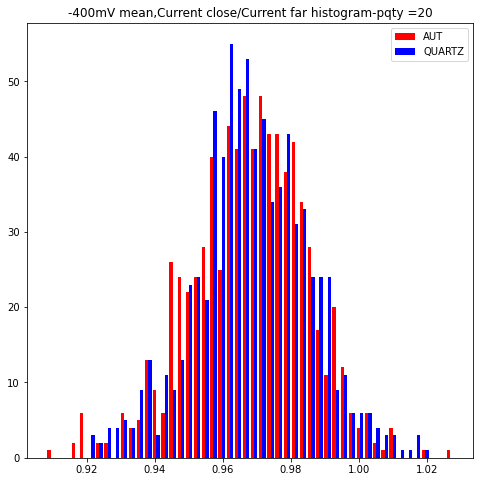

In [104]:
plt.figure()
plt.hist((I_aut,I_quartz),bins=bins,label = ('AUT','QUARTZ'),color = ('red','blue'))
plt.legend()
plt.title(title_prefix + " mean,Current close/Current far histogram-pqty =" +str(pqty))
plt.savefig(fig_save_path+title_prefix + " mean,Current close divide Current far histogram-pqty =" +str(pqty))
plt.show()

AUT: 0.967850 +- 0.060035
QUARTZ: 0.968635 +- 0.052033
40 39


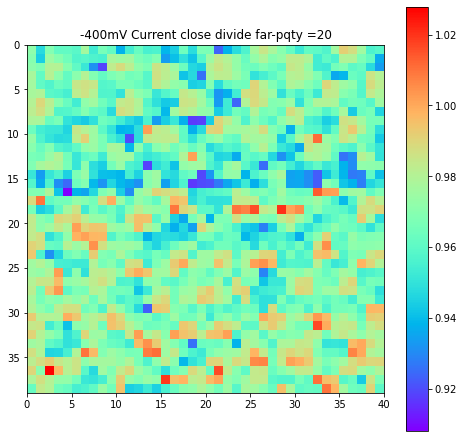

In [105]:
a = I_aut
mean = np.mean(a)
Max = np.max(a)
Min = np.min(a)
print("AUT: %lf +- %lf" %(mean,max(Max-mean,mean-Min)))
a = I_quartz
mean = np.mean(a)
Max = np.max(a)
Min = np.min(a)
print("QUARTZ: %lf +- %lf" %(mean,max(Max-mean,mean-Min)))

I_aut = np.reshape(I_aut,(Row-1,pqty))
I_quartz = np.reshape(I_quartz,(Row-1,pqty))

Current_normalized_data = np.hstack((I_aut,I_quartz))

plot_colormap(Current_normalized_data,title = title_prefix +  " Current close divide far-pqty =" +str(pqty),path = fig_save_path)

AUT: 0.061598 +- 0.120897
QUARTZ: 0.060227 +- 0.099411
40 39


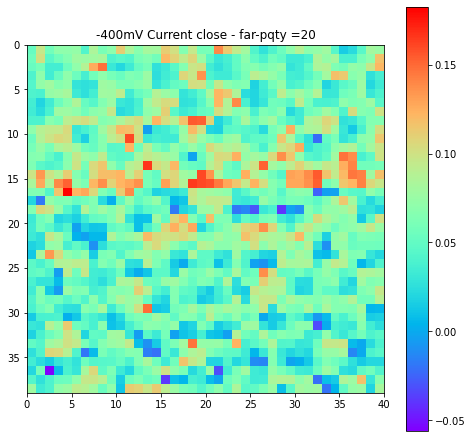

In [106]:
I_aut = I_aut_close-I_aut_far
I_quartz = I_quartz_close-I_quartz_far

a = I_aut
mean = np.mean(a)
Max = np.max(a)
Min = np.min(a)
print("AUT: %lf +- %lf" %(mean,max(Max-mean,mean-Min)))
a = I_quartz
mean = np.mean(a)
Max = np.max(a)
Min = np.min(a)
print("QUARTZ: %lf +- %lf" %(mean,max(Max-mean,mean-Min)))

I_aut = np.reshape(I_aut,(Row-1,pqty))
I_quartz = np.reshape(I_quartz,(Row-1,pqty))

Current_normalized_data_subs = np.hstack((I_aut,I_quartz))

plot_colormap(Current_normalized_data_subs,title = title_prefix +  " Current close - far-pqty =" +str(pqty),path = fig_save_path)


In [108]:
with open("result\\"+abfFile+'_current_div-pqty='+str(pqty)+'.csv', 'w', encoding='UTF8', newline='') as f:
    writer = csv.writer(f)

    # write the data
    for row in Current_normalized_data:
        writer.writerow(row)

In [109]:
with open("result\\"+abfFile+'_current_subs-pqty='+str(pqty)+'.csv', 'w', encoding='UTF8', newline='') as f:
    writer = csv.writer(f)

    # write the data
    for row in Current_normalized_data_subs:
        writer.writerow(row)

In [110]:
with open("result\\"+abfFile+'_EMF_div-pqty='+str(pqty)+'.csv', 'w', encoding='UTF8', newline='') as f:
    writer = csv.writer(f)

    # write the data
    for row in EMF_normalized_data:
        writer.writerow(row)

In [111]:
with open("result\\"+abfFile+'_EMF_subs-pqty='+str(pqty)+'.csv', 'w', encoding='UTF8', newline='') as f:
    writer = csv.writer(f)

    # write the data
    for row in EMF_normalized_data_subs:
        writer.writerow(row)

In [112]:
with open("result\\"+abfFile+'_EMF-pqty='+str(pqty)+'.csv', 'w', encoding='UTF8', newline='') as f:
    writer = csv.writer(f)

    # write the data
    for w,x,y,z in zip(aut_close,aut_far,quartz_close,quartz_far):
        writer.writerow([w,x,y,z])

In [113]:
with open("result\\"+abfFile+'-pqty='+str(pqty)+'_current.csv', 'w', encoding='UTF8', newline='') as f:
    writer = csv.writer(f)

    # write the data
    for w,x,y,z in zip(I_aut_close,I_aut_far,I_quartz_close,I_quartz_far):
        writer.writerow([w,x,y,z])

In [129]:
with open("result\\"+abfFile+'_EMF_close-pqty='+str(pqty)+'.csv', 'w', encoding='UTF8', newline='') as f:
    writer = csv.writer(f)

    # write the data
    w_close = np.hstack((np.reshape(aut_close,(Row-1,int(Col/2))),np.reshape(quartz_close,(Row-1,int(Col/2)))))
    for x in w_close:
        writer.writerow(x)

In [130]:
with open("result\\"+abfFile+'_EMF_far-pqty='+str(pqty)+'.csv', 'w', encoding='UTF8', newline='') as f:
    writer = csv.writer(f)

    # write the data
    w_far = np.hstack((np.reshape(aut_far,(Row-1,int(Col/2))),np.reshape(quartz_far,(Row-1,int(Col/2)))))
    for x in w_far:
        writer.writerow(x)

In [116]:
aut_far.shape

(780,)

In [120]:
np.reshape(aut_far,(39,20))

(20,)

In [126]:
np.hstack((np.array([1,2,3]),np.array([4,5,6])))

array([1, 2, 3, 4, 5, 6])